In [1]:
#!pip install pyod
#!pip install lightgbm
#!pip install keras
#!pip install tensorflow
# !pip install libfreetype6-dev
# !pip install pkgconfig
#!pip install feature_selector
#!pip install --upgrade pandas
#!pip install --upgrade numpy

In [1]:
import pandas as pd
import numpy as np
import pyod
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import preprocessing
from pyod.utils.data import evaluate_print

from pyod.models.pca import PCA
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM

from pyod.models.lof import LOF 
from pyod.models.cof import COF
from pyod.models.cblof import CBLOF
from pyod.models.loci import LOCI
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.sod import SOD

from pyod.models.abod import ABOD
from pyod.models.sos import SOS

from pyod.models.iforest import IForest
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.lscp import LSCP

from pyod.models.auto_encoder import AutoEncoder
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL

from sklearn.preprocessing import StandardScaler
#from feature_selector import FeatureSelector

from datetime import datetime
import time
np.set_printoptions(precision=3)

/home/andre/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
testingSet_pd = pd.read_csv('../Unbalanced_Samples/Sample_20K.csv',sep=',',header=0)
trainingSet_pd = pd.read_csv('../Unbalanced_Samples/Sample_60K.csv',sep=',',header=0)

import csv
with open('../Unbalanced_Samples/Sample_60K.csv', newline='') as f:
  csv_reader = csv.reader(f)
  header = next(csv_reader)

print("Features:")
for i in range(len(header)):
    header[i] = header[i]+" ("+str(i)+")"
    print(header[i])

Features:
Unnamed: 0 (0)
Flow ID (1)
Src IP (2)
Src Port (3)
Dst IP (4)
Dst Port (5)
Protocol (6)
Timestamp (7)
Flow Duration (8)
Tot Fwd Pkts (9)
Tot Bwd Pkts (10)
TotLen Fwd Pkts (11)
TotLen Bwd Pkts (12)
Fwd Pkt Len Max (13)
Fwd Pkt Len Min (14)
Fwd Pkt Len Mean (15)
Fwd Pkt Len Std (16)
Bwd Pkt Len Max (17)
Bwd Pkt Len Min (18)
Bwd Pkt Len Mean (19)
Bwd Pkt Len Std (20)
Flow Byts/s (21)
Flow Pkts/s (22)
Flow IAT Mean (23)
Flow IAT Std (24)
Flow IAT Max (25)
Flow IAT Min (26)
Fwd IAT Tot (27)
Fwd IAT Mean (28)
Fwd IAT Std (29)
Fwd IAT Max (30)
Fwd IAT Min (31)
Bwd IAT Tot (32)
Bwd IAT Mean (33)
Bwd IAT Std (34)
Bwd IAT Max (35)
Bwd IAT Min (36)
Fwd PSH Flags (37)
Bwd PSH Flags (38)
Fwd URG Flags (39)
Bwd URG Flags (40)
Fwd Header Len (41)
Bwd Header Len (42)
Fwd Pkts/s (43)
Bwd Pkts/s (44)
Pkt Len Min (45)
Pkt Len Max (46)
Pkt Len Mean (47)
Pkt Len Std (48)
Pkt Len Var (49)
FIN Flag Cnt (50)
SYN Flag Cnt (51)
RST Flag Cnt (52)
PSH Flag Cnt (53)
ACK Flag Cnt (54)
URG Flag Cnt (55)
CW

In [3]:
def ipToNumber(ip):
    if(isinstance(ip, float)):
        return ip
    ip = ip.split(".")
    final_ip = 0
    multiplier = 10**9
    for i in ip:
        final_ip+=int(i)*multiplier
        multiplier/=10**3
    return final_ip

def toTimestamp(hour):
    if(isinstance(hour, float)):
        return hour
    hour = hour.strip()
    if hour.rfind("AM") != -1 or hour.rfind("PM")!=-1:
        timestamp = time.mktime(datetime.strptime(hour, "%d/%m/%Y %I:%M:%S %p").timetuple())
    else:
        timestamp = time.mktime(datetime.strptime(hour, "%d/%m/%Y %I:%M:%S").timetuple())
    return timestamp

def labelToBinary(label):
    if isinstance(label, int):
        return label
    return 1 if (label == "ddos") else 0

def datasetToFloat(tSet):
    for f in tSet.columns:
        if f == "Src IP" or f == "Dst IP":
            tSet[f] = [ipToNumber(ip) for ip in tSet[f].values]
        elif f == "Timestamp":
            tSet[f] = [toTimestamp(t) for t in tSet[f].values]
        elif f == "Label":
            tSet[f] = [labelToBinary(l) for l in tSet[f].values]
        elif f == "Flow ID":   #drops flow Id, which is a composition of other features
            tSet[f] = [0 for i in range(len(tSet[f]))]
    return tSet
        
trainingSet_pd = datasetToFloat(trainingSet_pd)
testingSet_pd = datasetToFloat(testingSet_pd)

In [4]:
def deleteUnknown(tSet_):
    tSet = tSet_.values
    tSet = tSet.astype(float)
    np.random.shuffle(tSet)
    #removing nan or inf elements
    for i in range (tSet.shape[0]-1, 0, -1):
        for j in range(0, tSet.shape[1]):
            tSet[i, j] = float(tSet[i, j])
            if (np.isinf(tSet[i, j]) or np.isnan(tSet[i, j])):
                tSet = np.delete(tSet, i, axis=0)
    return pd.DataFrame(tSet, columns = header)

trainingSet_pd = deleteUnknown(trainingSet_pd)
testingSet_pd = deleteUnknown(testingSet_pd)

In [5]:
def getDatasetLabel(tSet):
    labels = tSet["Label (84)"]
    tSet = tSet.drop("Label (84)", axis=1)
    return tSet, np.array(labels.values).astype(int)

trainingSet_pd, y_train = getDatasetLabel(trainingSet_pd)
testingSet_pd, y_test = getDatasetLabel(testingSet_pd)

In [6]:
trainingSet_pd

Unnamed: 0 (0)  Flow ID (1)    Src IP (2)  Src Port (3)    Dst IP (4)  \
0           7466663.0          0.0  1.862321e+11       53829.0  1.720311e+11   
1           3399477.0          0.0  1.720311e+11          80.0  1.821919e+10   
2           6388672.0          0.0  1.720311e+11       49585.0  1.731942e+11   
3           4411920.0          0.0  1.720311e+11       63515.0  1.720310e+11   
4           2358312.0          0.0  1.720311e+11       61088.0  1.720310e+11   
...               ...          ...           ...           ...           ...   
59628       2801765.0          0.0  1.720311e+11          80.0  1.821919e+10   
59629       1382691.0          0.0  2.319610e+10         443.0  1.720311e+11   
59630       1981034.0          0.0  1.720311e+11       58868.0  1.720310e+11   
59631       1046866.0          0.0  1.720311e+11       52435.0  1.720310e+11   
59632       7713165.0          0.0  2.032051e+11       16371.0  1.720311e+11   

       Dst Port (5)  Protocol (6)  Timestamp (7)  Flow Duration (8)  \
0             445.0           6.0   1.519135e+09           488033.0   
1           39258.0           6.0   1.518831e+09          4425134.0   
2             443.0           6.0   1.519130e+09           516529.0   
3              53.0          17.0   1.519097e+09             7993.0   
4              53.0          17.0   1.519104e+09            18146.0   
...             ...           ...            ...                ...   
59628       39034.0           6.0   1.518831e+09          4654885.0   
59629       52387.0           6.0   1.519104e+09              130.0   
59630          53.0          17.0   1.519096e+09              947.0   
59631          53.0          17.0   1.519137e+09            53036.0   
59632         445.0           6.0   1.519135e+09           238633.0   

       Tot Fwd Pkts (9)  ...  Fwd Act Data Pkts (74)  Fwd Seg Size Min (75)  \
0                   5.0  ...                     3.0                   20.0   
1                   4.0  ...                     1.0                    0.0   
2                  10.0  ...                     4.0                   20.0   
3                   1.0  ...                     0.0                    8.0   
4                   1.0  ...                     0.0                    8.0   
...                 ...  ...                     ...                    ...   
59628               4.0  ...                     1.0                    0.0   
59629               3.0  ...                     1.0                   20.0   
59630               1.0  ...                     0.0                    8.0   
59631               2.0  ...                     1.0                    8.0   
59632               3.0  ...                     0.0                   20.0   

       Active Mean (76)  Active Std (77)  Active Max (78)  Active Min (79)  \
0                   0.0              0.0              0.0              0.0   
1                   0.0              0.0              0.0              0.0   
2                   0.0              0.0              0.0              0.0   
3                   0.0              0.0              0.0              0.0   
4                   0.0              0.0              0.0              0.0   
...                 ...              ...              ...              ...   
59628               0.0              0.0              0.0              0.0   
59629               0.0              0.0              0.0              0.0   
59630               0.0              0.0              0.0              0.0   
59631               0.0              0.0              0.0              0.0   
59632               0.0              0.0              0.0              0.0   

       Idle Mean (80)  Idle Std (81)  Idle Max (82)  Idle Min (83)  
0                 0.0            0.0            0.0            0.0  
1                 0.0            0.0            0.0            0.0  
2                 0.0            0.0            0.0            0.0  
3                 0.0          

In [7]:
testingSet_pd

Unnamed: 0 (0)  Flow ID (1)    Src IP (2)  Src Port (3)    Dst IP (4)  \
0           4843965.0          0.0  1.720311e+11       52520.0  7.202109e+10   
1           1919056.0          0.0  1.720311e+11          80.0  1.821919e+10   
2           6972931.0          0.0  2.120921e+11       52409.0  1.720311e+11   
3           2031000.0          0.0  1.720311e+11          80.0  1.821901e+10   
4             44050.0          0.0  1.821903e+10       55012.0  1.720311e+11   
...               ...          ...           ...           ...           ...   
19891       3347186.0          0.0  1.720311e+11       50670.0  2.305209e+10   
19892       4068651.0          0.0  1.720311e+11       55081.0  1.720310e+11   
19893        309110.0          0.0  1.921680e+11       62448.0  1.722170e+11   
19894       5463263.0          0.0  1.720311e+11       49486.0  1.720310e+11   
19895       1918189.0          0.0  2.092220e+11        2290.0  1.720311e+11   

       Dst Port (5)  Protocol (6)  Timestamp (7)  Flow Duration (8)  \
0              80.0           6.0   1.519097e+09         34155459.0   
1           36338.0           6.0   1.518830e+09          4817796.0   
2            3389.0           6.0   1.519131e+09          1978592.0   
3           50941.0           6.0   1.519270e+09           596233.0   
4              80.0           6.0   1.519133e+09          1262323.0   
...             ...           ...            ...                ...   
19891          80.0           6.0   1.519131e+09              122.0   
19892          53.0          17.0   1.519106e+09             1030.0   
19893         443.0           6.0   1.499141e+09           153076.0   
19894          53.0          17.0   1.519112e+09            13075.0   
19895        3128.0           6.0   1.519101e+09          1002281.0   

       Tot Fwd Pkts (9)  ...  Fwd Act Data Pkts (74)  Fwd Seg Size Min (75)  \
0                   5.0  ...                     3.0                   20.0   
1                   4.0  ...                     1.0                    0.0   
2                   8.0  ...                     5.0                   20.0   
3                   4.0  ...                     1.0                    0.0   
4                   3.0  ...                     1.0                   20.0   
...                 ...  ...                     ...                    ...   
19891               2.0  ...                     0.0                   20.0   
19892               1.0  ...                     0.0                    8.0   
19893               9.0  ...                     5.0                    0.0   
19894               1.0  ...                     0.0                    8.0   
19895               2.0  ...                     0.0                   40.0   

       Active Mean (76)  Active Std (77)  Active Max (78)  Active Min (79)  \
0          11251.666667         21.36196          11276.0          11236.0   
1              0.000000          0.00000              0.0              0.0   
2              0.000000          0.00000              0.0              0.0   
3              0.000000          0.00000              0.0              0.0   
4              0.000000          0.00000              0.0              0.0   
...                 ...              ...              ...              ...   
19891          0.000000          0.00000              0.0              0.0   
19892          0.000000          0.00000              0.0              0.0   
19893          0.000000          0.00000              0.0              0.0   
19894          0.000000          0.00000              0.0              0.0   
19895          0.000000          0.00000              0.0              0.0   

       Idle Mean (80)  Idle Std (81)  Idle Max (82)  Idle Min (83)  
0        1.015501e+07   50256.384215     10191500.0     10097686.0  
1        0.000000e+00       0.000000            0.0            0.0  
2        0.000000e+00       0.000000            0.0            0.0  
3        0.000000e+00       0.0

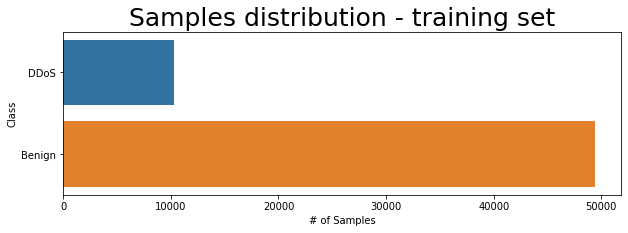

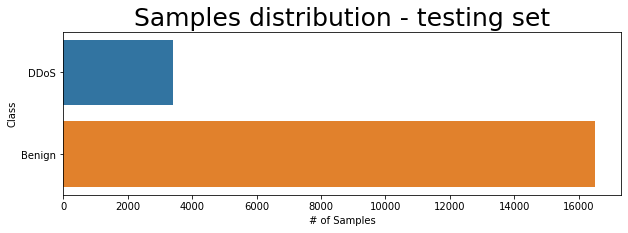

In [8]:
def plotDistribution(tLabels, t):
    pyplot.subplots(figsize=(10, 3))
    distribution = pd.DataFrame({"Class": ["DDoS","Benign"],
                                 "# of Samples":  [tLabels.sum() , tLabels.size - tLabels.sum()]})
    sns.barplot(data=distribution, y="Class", x="# of Samples").set_title("Samples distribution - "+t, fontsize=25)
    pyplot.show()

plotDistribution(y_train, "training set")
plotDistribution(y_test, "testing set")

Training Correlation Matrix


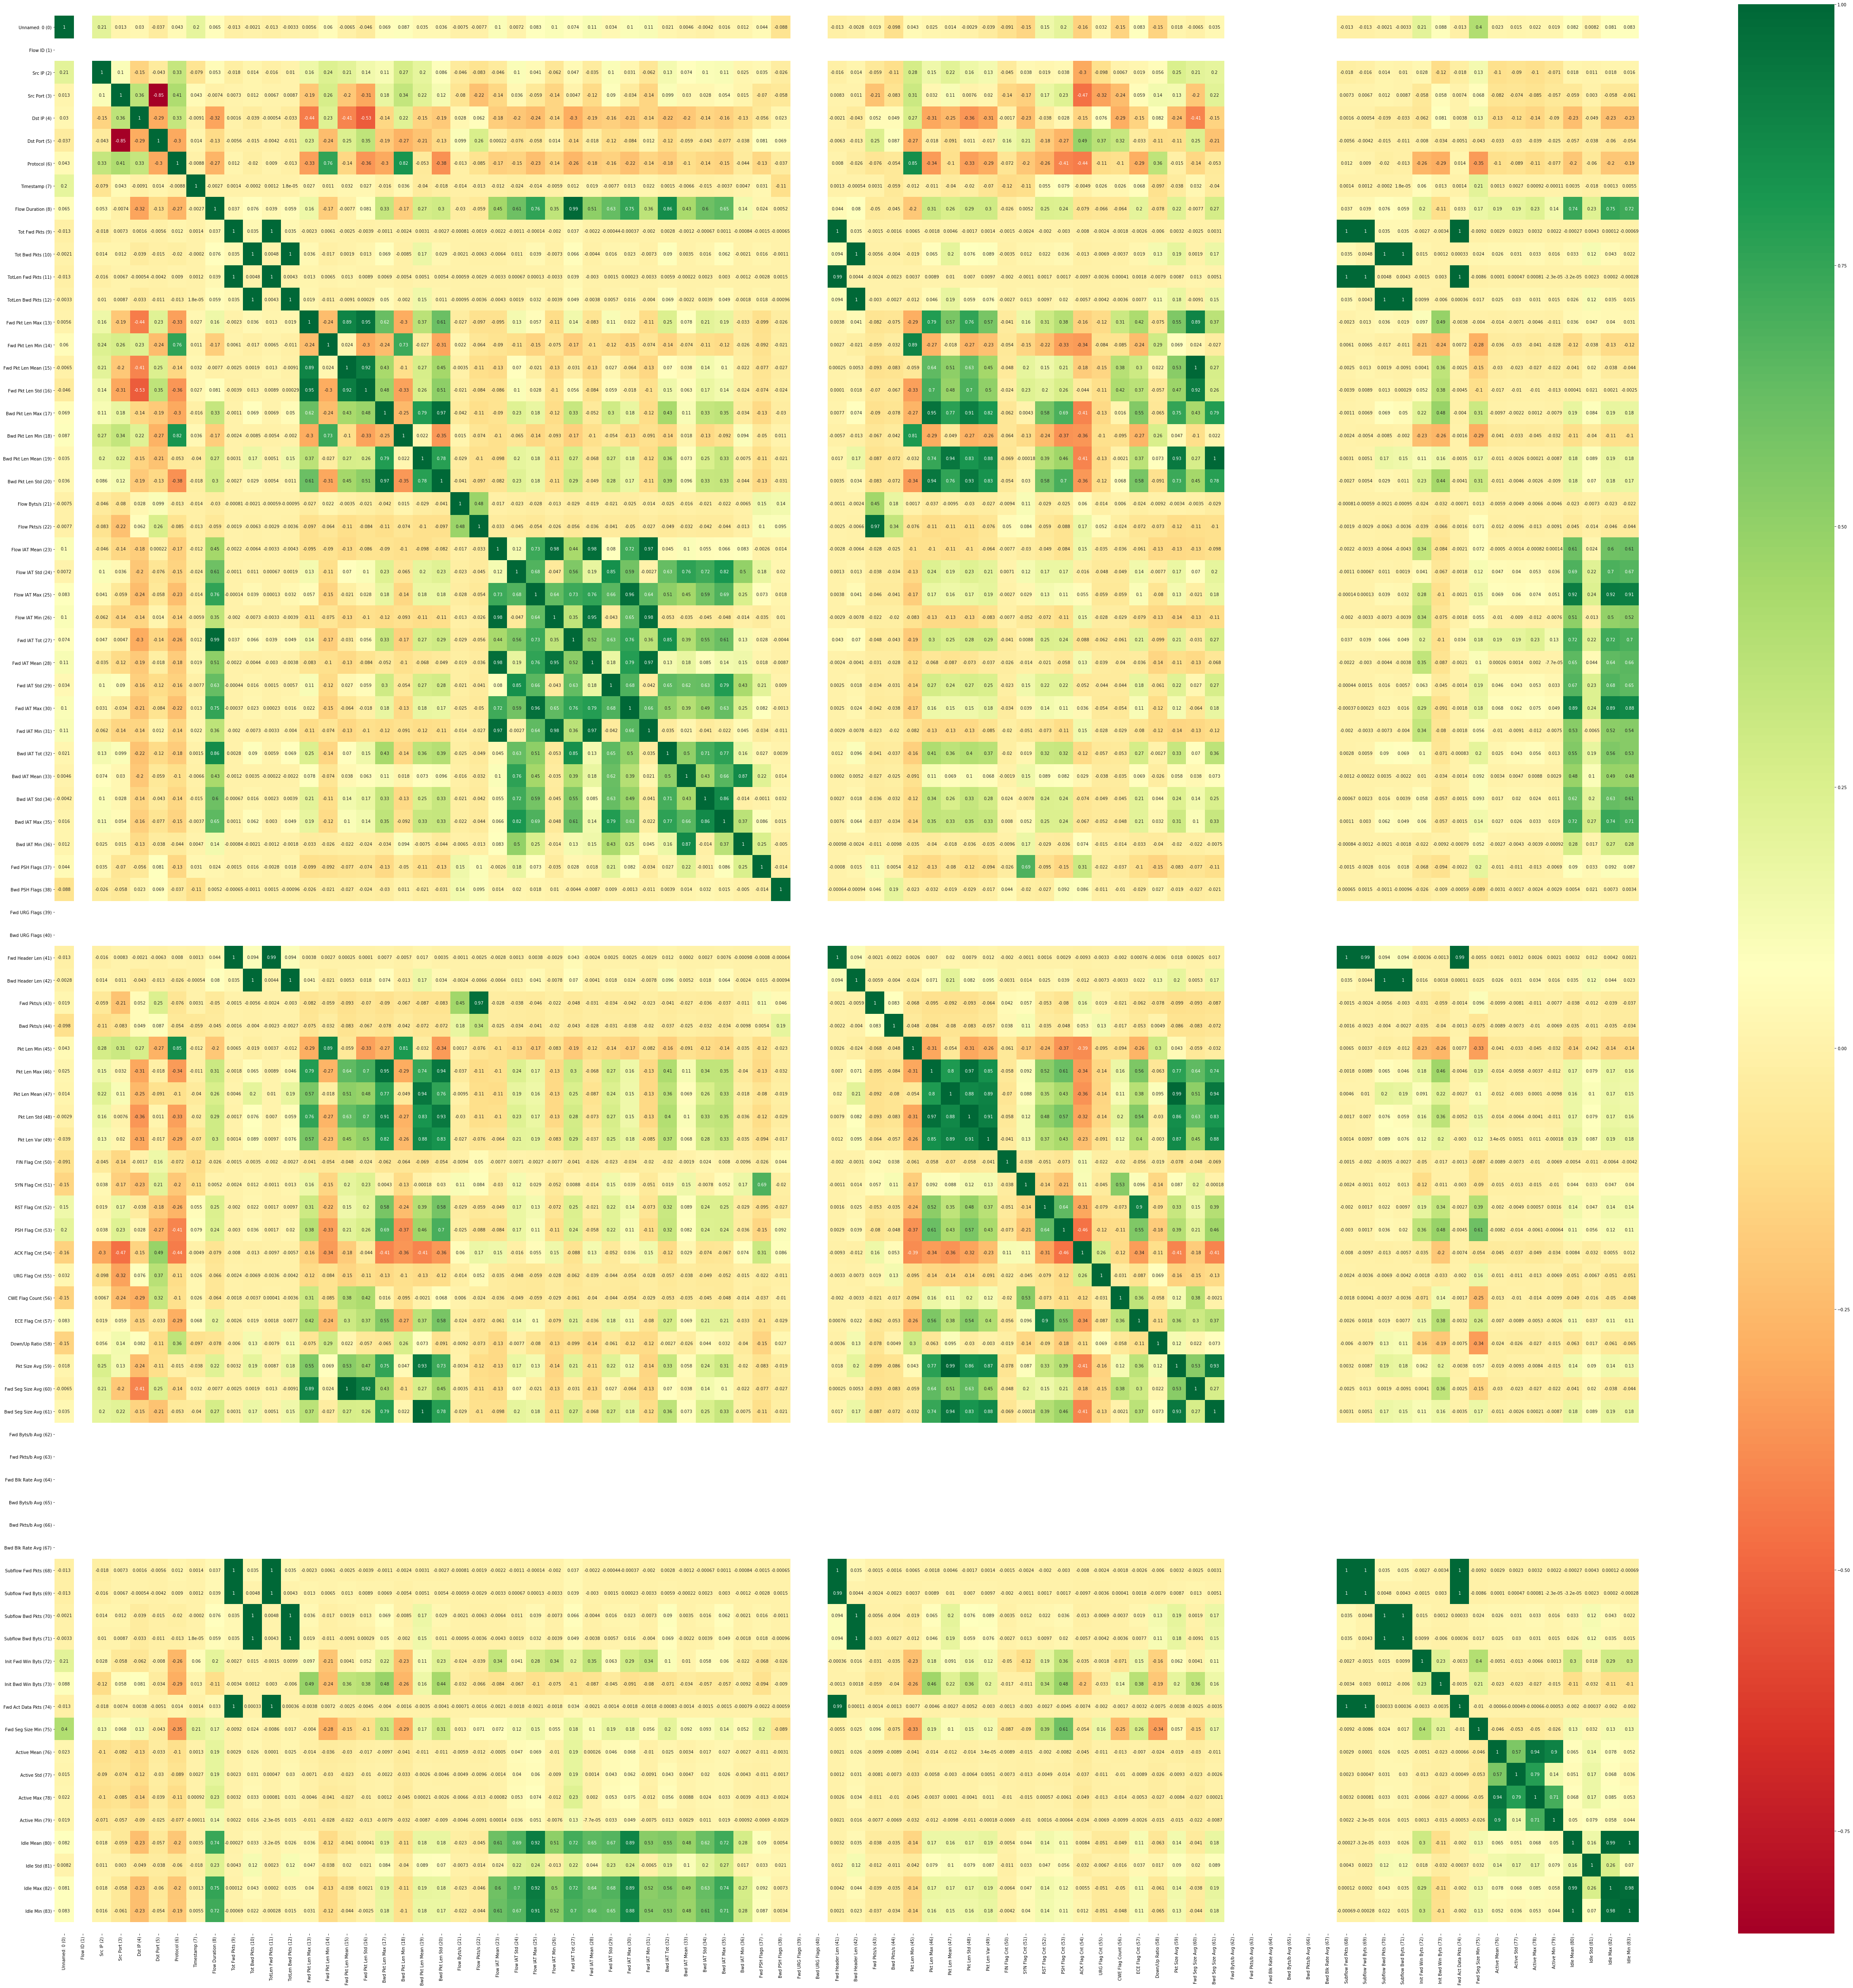

In [9]:
def printCorrelationMatrix(tSet):
    corrmat = tSet.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(len(tSet.columns), len(tSet.columns)))
    g=sns.heatmap(tSet[top_corr_features].corr(),annot=True,cmap="RdYlGn")    #plot heat map
    g.set_ylim(g.get_ylim()[0]+0.5, g.get_ylim()[1]-0.5)                      #plot heat map

print("Training Correlation Matrix")
printCorrelationMatrix(trainingSet_pd)

In [10]:
#Features originalmente não float: 7 4 2 1 0
#Feaatures sempre 0: 67, 66, 65, 64, 63, 62, 40, 39
#features com correlação próxima de zero, vide loop abaixo: 73, 71, 70, 50, 42, 34, 12, 10 

def appendDropIndexByCorrelationWithLabel(tSet, labels, dList, tolerance):
    tSet["Label (84)"] = labels
    corrmat = tSet.corr()
    top_corr_features = corrmat.index
    cm = tSet[top_corr_features].corr().values
    tSet.drop("Label (84)", axis=1)
    dList_return = dList
    for i in range(cm.shape[0]-1, 0, -1):
        if cm[cm.shape[0]-1, i] <= -tolerance or cm[cm.shape[0]-1, i] >= tolerance:
            if i not in dList:
                dList_return.append(i)
    return dList_return
    

droppingList = [67, 66, 65, 64, 63, 62, 40, 39,       1, 0]
#droppingList = appendDropIndexByCorrelationWithLabel(trainingSet_pd, y_train, droppingList, 0.4)
droppingLabels = [trainingSet_pd.columns[i] for i in droppingList]

trainingSet_pd = trainingSet_pd.drop(droppingLabels, axis=1)
testingSet_pd = testingSet_pd.drop(droppingLabels, axis=1)
header = trainingSet_pd.columns

print("Features dropadas: ")
for dL in droppingLabels:
    print(dL)

Features dropadas: 
Bwd Blk Rate Avg (67)
Bwd Pkts/b Avg (66)
Bwd Byts/b Avg (65)
Fwd Blk Rate Avg (64)
Fwd Pkts/b Avg (63)
Fwd Byts/b Avg (62)
Bwd URG Flags (40)
Fwd URG Flags (39)
Flow ID (1)
Unnamed: 0 (0)


In [46]:
"""testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
fs = FeatureSelector(data = testing_set, labels = y_test)
fs.identify_collinear(correlation_threshold = 0.85)

#gets real indexes of collinear above threshold features
real_indexs = np.zeros(fs.record_collinear.shape[0])
j = 0
for i in range(header.size):
    if (header[i] == fs.record_collinear.iloc[j, 0]):
        real_indexs[j] = i
        j = j+1

real_indexs = np.unique(real_indexs)
for i in range(real_indexs.size - 1, -1, -1):
    np.delete(testingSet, real_indexs[i], axis = 1)

print(real_indexs)
fs.record_collinear.head()"""

'testing_set = pd.DataFrame(testingSet)\ntesting_set.columns = header\nfs = FeatureSelector(data = testing_set, labels = y_test)\nfs.identify_collinear(correlation_threshold = 0.85)\n\n#gets real indexes of collinear above threshold features\nreal_indexs = np.zeros(fs.record_collinear.shape[0])\nj = 0\nfor i in range(header.size):\n    if (header[i] == fs.record_collinear.iloc[j, 0]):\n        real_indexs[j] = i\n        j = j+1\n\nreal_indexs = np.unique(real_indexs)\nfor i in range(real_indexs.size - 1, -1, -1):\n    np.delete(testingSet, real_indexs[i], axis = 1)\n\nprint(real_indexs)\nfs.record_collinear.head()'

In [12]:
#Aplica a padronização z-score
"""testingSetSaved = testingSet

mi = np.mean(testingSet)
sigma = np.std(testingSet)
testingSet = (testingSet - mi) / sigma"""

#Aplica regularização default sk-learn
scaler = StandardScaler()
scaler.fit_transform(testingSet)

array([[-0.697, -0.424, -1.315, ..., -0.093, -0.294, -0.283],
       [-1.248,  1.16 , -0.064, ..., -0.093, -0.294, -0.283],
       [ 1.811,  0.612,  1.454, ..., -0.093, -0.294, -0.283],
       ...,
       [-1.26 ,  1.231, -0.064, ..., -0.093, -0.294, -0.283],
       [-0.923,  1.318, -0.242, ..., -0.093, -0.294, -0.283],
       [-1.265, -1.309, -0.726, ..., -0.093, -0.294, -0.283]])

In [33]:
def printResults(clf_name, predicted, expected):
    print("\nResults - "+clf_name+":")
    truePositive = 0
    trueNegative = 0
    falsePositive = 0
    falseNegative = 0

    for i in range(expected.size):
        if(expected[i] == 1 and predicted[i] == 1):
            truePositive = truePositive+1
        elif (expected[i] == 0 and predicted[i] == 0):
            trueNegative = trueNegative+1
        elif (expected[i] == 0 and predicted[i] == 1):
            falsePositive = falsePositive+1
        else:
            falseNegative = falseNegative+1

    print("Confusion Matrix:")
    print("               Actual")
    print("Predicted  ", truePositive, " | ", falsePositive)
    print("           ",falseNegative, " | ", trueNegative,"\n")

    #####################################################################

#     fpr, tpr, threshold = metrics.roc_curve(expected, scores)
#     roc_auc = metrics.auc(fpr, tpr)

#     plt.title('Receiver Operating Characteristic - '+clf_name)
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
    
    #gets usual metrics based on results obtained
    total = expected.shape[0]
    
    accuracy = (truePositive+trueNegative)/total
    print("Accuracy: ", accuracy)
    
    if(truePositive+falsePositive != 0):
        precision = truePositive/(truePositive+falsePositive)
        print("Precision: ", precision)
    else:
        precision = 0
        print("Precision: -")
        
    if(truePositive+falseNegative != 0):
        recall = truePositive/(truePositive+falseNegative)
        print("Recall: ", recall)
    else:
        recall = 0
        print("Recall: -")
        
    if(recall + precision != 0):
        f1 = 2*(recall*precision)/(recall+precision)
        print("F1-score: ", f1)
    else:
        print("F1-score: -")
    

    

outliers_fraction = 0.17
def testMethod(clf, clf_name, fitSet, predSet, labels_test, labels_train=[-1]):
    start_fit = datetime.now()
    if(labels_train[0] == -1):
        clf.fit(fitSet)
    else:
        clf.fit(fitSet, labels_train)
        
    #####################################################################
    if(labels_train[0] == -1):
        y_test_pred = clf.predict(predSet)  # outlier labels (0 or 1)
        y_test_scores = clf.decision_function(predSet)  # outlier scores
        end_predict = datetime.now()
        printResults(clf_name, y_test_pred, labels_test)
        evaluate_print(clf_name, expected, scores)
    else:
        y_test_pred = clf.predict(predSet)  # outlier labels (0 or 1)
        y_test_scores = clf.predict_proba(predSet)  # outlier scores
        end_predict = datetime.now()
        printResults(clf_name, y_test_pred, labels_test)
    
    #####################################################################
    duration = end_predict - start_fit
    print("Duration: ", duration.total_seconds(), " seconds")
    print("\n")
    print("#####################################################################")


Results - PCA:
Confusion Matrix:
               Actual
Predicted   2170  |  8030
            8086  |  41714 

PCA ROC:0.5791, precision @ rank n:0.2124


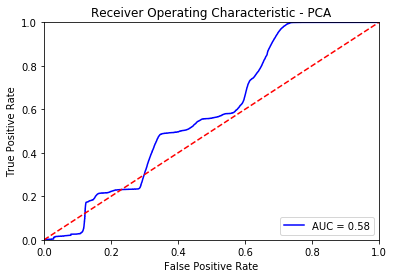

Accuracy:  0.7314
Precision:  0.21274509803921568
Recall:  0.21158346333853353
F1-score:  0.2121626906531091
Duration:  2.035688  seconds



Results - MCD:
Confusion Matrix:
               Actual
Predicted   848  |  9352
            9408  |  40392 

MCD ROC:0.4614, precision @ rank n:0.0829


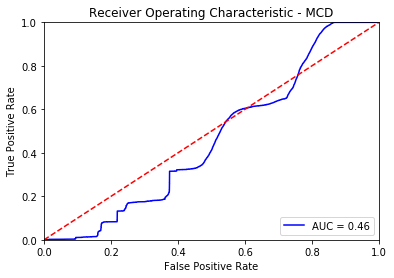

Accuracy:  0.6873333333333334
Precision:  0.08313725490196078
Recall:  0.08268330733229329
F1-score:  0.08290965975752834
Duration:  38.077569  seconds



Results - OCSVM:
Confusion Matrix:
               Actual
Predicted   0  |  0
            10256  |  49744 

OCSVM ROC:0.4998, precision @ rank n:0.0


/home/rudda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


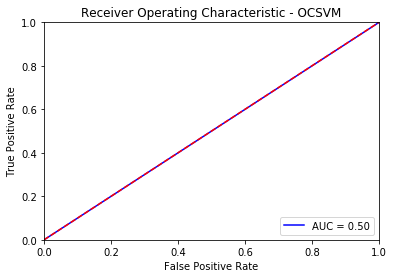

Accuracy:  0.8290666666666666
Precision: -
Recall:  0.0
F1-score: -
Duration:  1528.687349  seconds




In [14]:
#Linear Models
classifiers = {
    'PCA': PCA(contamination= outliers_fraction),
    'MCD': MCD(contamination= outliers_fraction),
    'OCSVM': OCSVM(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name, testingSet, testingSet)


Results - LOF:
Confusion Matrix:
               Actual
Predicted   819  |  8361
            9437  |  41383 

LOF ROC:0.4188, precision @ rank n:0.0883


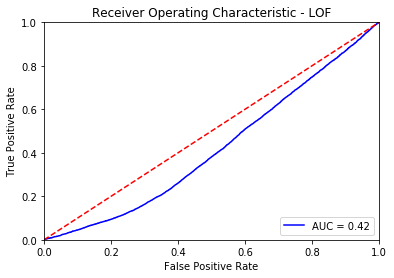

Accuracy:  0.7033666666666667
Precision:  0.0892156862745098
Recall:  0.07985569422776911
F1-score:  0.08427660012348219
Duration:  47.024687  seconds



Results - CBLOF:
Confusion Matrix:
               Actual
Predicted   1331  |  8869
            8925  |  40875 

CBLOF ROC:0.6082, precision @ rank n:0.1348


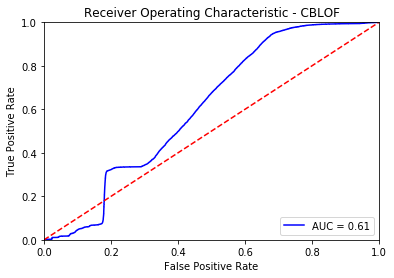

Accuracy:  0.7034333333333334
Precision:  0.13049019607843138
Recall:  0.1297776911076443
F1-score:  0.13013296832225266
Duration:  8.91354  seconds



Results - HBOS:
Confusion Matrix:
               Actual
Predicted   1828  |  8372
            8428  |  41372 

HBOS ROC:0.66, precision @ rank n:0.1782


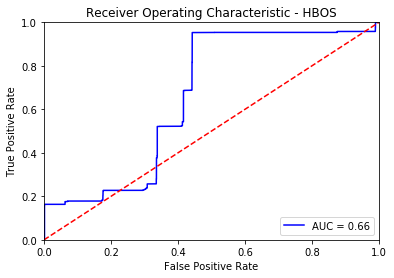

Accuracy:  0.72
Precision:  0.17921568627450982
Recall:  0.17823712948517942
F1-score:  0.17872506843957764
Duration:  2.016852  seconds



Results - kNN:
Confusion Matrix:
               Actual
Predicted   651  |  9015
            9605  |  40729 

kNN ROC:0.3629, precision @ rank n:0.0716


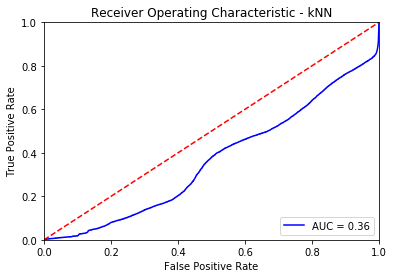

Accuracy:  0.6896666666666667
Precision:  0.06734947237740534
Recall:  0.06347503900156007
F1-score:  0.06535488404778637
Duration:  272.223706  seconds



Results - AvgKNN:
Confusion Matrix:
               Actual
Predicted   499  |  7952
            9757  |  41792 

AvgKNN ROC:0.3569, precision @ rank n:0.0683


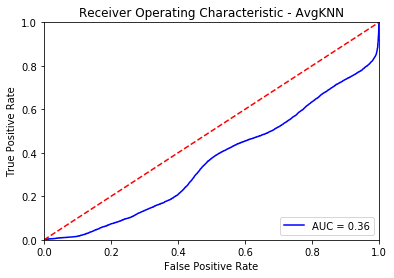

Accuracy:  0.70485
Precision:  0.05904626671399835
Recall:  0.048654446177847116
F1-score:  0.053349013738172885
Duration:  318.17992  seconds



Results - MedKNN:
Confusion Matrix:
               Actual
Predicted   609  |  8590
            9647  |  41154 

MedKNN ROC:0.3553, precision @ rank n:0.0667


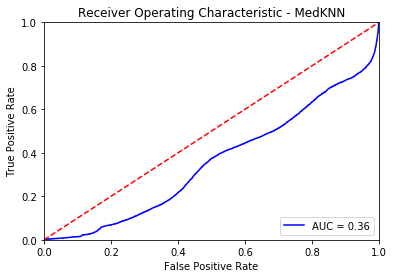

Accuracy:  0.69605
Precision:  0.06620284813566692
Recall:  0.0593798751950078
F1-score:  0.0626060138781804
Duration:  343.22045  seconds



Results - SOD:
Confusion Matrix:
               Actual
Predicted   448  |  9752
            9808  |  39992 

SOD ROC:0.3842, precision @ rank n:0.044


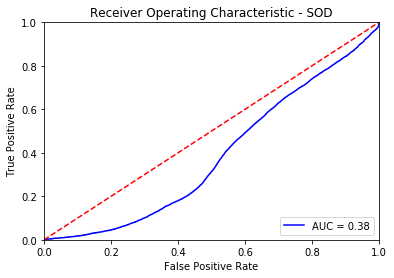

Accuracy:  0.674
Precision:  0.04392156862745098
Recall:  0.0436817472698908
F1-score:  0.043801329683222534
Duration:  5327.821198  seconds




In [15]:
#Proximity Based
classifiers = {
    #'COF': COF(contamination= outliers_fraction),  #Apresentou erros de execução.
    'LOF': LOF(contamination = outliers_fraction),
    'CBLOF':CBLOF(contamination= outliers_fraction),
    #'LOCI':LOCI(contamination= outliers_fraction),   #Travou a máquina de execução repetidas vezes.
    'HBOS': HBOS(contamination= outliers_fraction),
    'kNN': KNN(method='largest', contamination= outliers_fraction),
    'AvgKNN': KNN(method='mean', contamination= outliers_fraction),
    'MedKNN': KNN(method='median', contamination= outliers_fraction),
    'SOD': SOD(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name, testingSet, testingSet)    


Results - ABOD:
Confusion Matrix:
               Actual
Predicted   574  |  9648
            9682  |  40096 

ABOD ROC:0.3426, precision @ rank n:0.0564


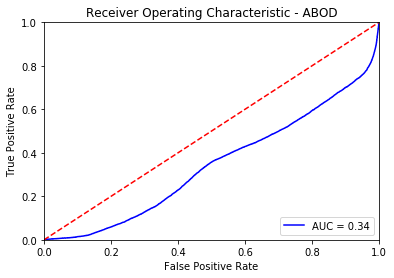

Accuracy:  0.6778333333333333
Precision:  0.05615339463901389
Recall:  0.05596723868954758
F1-score:  0.056060162125207535
Duration:  64.97771  seconds




In [16]:
#Probabilistic tests
classifiers = {
    'ABOD': ABOD(contamination = outliers_fraction),
    #'SOS': SOS(contamination = outliers_fraction) #Apresentou erros de execução.
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name, testingSet, testingSet)

/home/rudda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)



Results - Isolation Forest:
Confusion Matrix:
               Actual
Predicted   1497  |  8703
            8759  |  41041 

Isolation Forest ROC:0.5059, precision @ rank n:0.1483


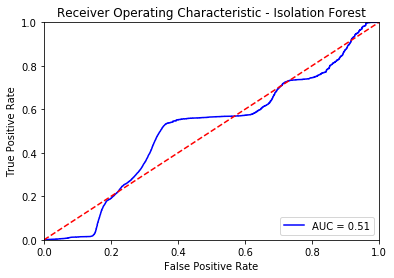

Accuracy:  0.7089666666666666
Precision:  0.14676470588235294
Recall:  0.14596333853354135
F1-score:  0.14636292530308956
Duration:  15.857569  seconds



Results - Feature Bagging:
Confusion Matrix:
               Actual
Predicted   784  |  8397
            9472  |  41347 

Feature Bagging ROC:0.4026, precision @ rank n:0.0874


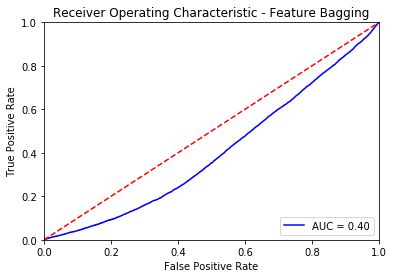

Accuracy:  0.7021833333333334
Precision:  0.08539374795773881
Recall:  0.07644305772230889
F1-score:  0.08067088542470545
Duration:  373.204154  seconds




In [17]:
#Ensenbles tests
listDetectors = detector_list=[HBOS(),
                               PCA(),
                               ABOD(),
                               LOF(),
                               KNN()]
classifiers = {
    'Isolation Forest': IForest(contamination = outliers_fraction),
    'Feature Bagging': FeatureBagging(contamination = outliers_fraction)
    #'LSCP': LSCP(detector_list = listDetectors, contamination = outliers_fraction) #Still couldn't get it to work
    #XGBOD tests are in a separate file
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name, testingSet, testingSet)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 76)                5852      
_________________________________________________________________
dropout_1 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                5852      
_________________________________________________________________
dropout_2 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 616       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                

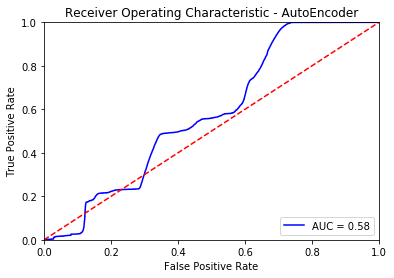

Accuracy:  0.7314
Precision:  0.21274509803921568
Recall:  0.21158346333853353
F1-score:  0.2121626906531091
Duration:  48.514138  seconds


Epoch 1 of 60

Testing for epoch 1 index 1:


/home/rudda/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:

Testing for epoch 1 index 25:

Testing for epoch 1 index 26:

Testing for epoch 1 index 27:

Testing for epoch 1 index 28:

Testing for epoch 1 index 29:

Testing for epoch 1 index 30:

Testing for epoch 1 index 31:

Testing for epoch 1 index 32:

Testing for epoch 1 index 33:

Testing for epo


Testing for epoch 3 index 42:

Testing for epoch 3 index 43:

Testing for epoch 3 index 44:

Testing for epoch 3 index 45:

Testing for epoch 3 index 46:

Testing for epoch 3 index 47:

Testing for epoch 3 index 48:

Testing for epoch 3 index 49:

Testing for epoch 3 index 50:

Testing for epoch 3 index 51:

Testing for epoch 3 index 52:

Testing for epoch 3 index 53:

Testing for epoch 3 index 54:

Testing for epoch 3 index 55:

Testing for epoch 3 index 56:

Testing for epoch 3 index 57:

Testing for epoch 3 index 58:

Testing for epoch 3 index 59:

Testing for epoch 3 index 60:

Testing for epoch 3 index 61:

Testing for epoch 3 index 62:

Testing for epoch 3 index 63:

Testing for epoch 3 index 64:

Testing for epoch 3 index 65:

Testing for epoch 3 index 66:

Testing for epoch 3 index 67:

Testing for epoch 3 index 68:

Testing for epoch 3 index 69:

Testing for epoch 3 index 70:

Testing for epoch 3 index 71:

Testing for epoch 3 index 72:

Testing for epoch 3 index 73:

Testing


Testing for epoch 5 index 83:

Testing for epoch 5 index 84:

Testing for epoch 5 index 85:

Testing for epoch 5 index 86:

Testing for epoch 5 index 87:

Testing for epoch 5 index 88:

Testing for epoch 5 index 89:

Testing for epoch 5 index 90:

Testing for epoch 5 index 91:

Testing for epoch 5 index 92:

Testing for epoch 5 index 93:

Testing for epoch 5 index 94:

Testing for epoch 5 index 95:

Testing for epoch 5 index 96:

Testing for epoch 5 index 97:

Testing for epoch 5 index 98:

Testing for epoch 5 index 99:

Testing for epoch 5 index 100:

Testing for epoch 5 index 101:

Testing for epoch 5 index 102:

Testing for epoch 5 index 103:

Testing for epoch 5 index 104:

Testing for epoch 5 index 105:

Testing for epoch 5 index 106:

Testing for epoch 5 index 107:

Testing for epoch 5 index 108:

Testing for epoch 5 index 109:

Testing for epoch 5 index 110:

Testing for epoch 5 index 111:

Testing for epoch 5 index 112:

Testing for epoch 5 index 113:

Testing for epoch 5 inde


Testing for epoch 8 index 8:

Testing for epoch 8 index 9:

Testing for epoch 8 index 10:

Testing for epoch 8 index 11:

Testing for epoch 8 index 12:

Testing for epoch 8 index 13:

Testing for epoch 8 index 14:

Testing for epoch 8 index 15:

Testing for epoch 8 index 16:

Testing for epoch 8 index 17:

Testing for epoch 8 index 18:

Testing for epoch 8 index 19:

Testing for epoch 8 index 20:

Testing for epoch 8 index 21:

Testing for epoch 8 index 22:

Testing for epoch 8 index 23:

Testing for epoch 8 index 24:

Testing for epoch 8 index 25:

Testing for epoch 8 index 26:

Testing for epoch 8 index 27:

Testing for epoch 8 index 28:

Testing for epoch 8 index 29:

Testing for epoch 8 index 30:

Testing for epoch 8 index 31:

Testing for epoch 8 index 32:

Testing for epoch 8 index 33:

Testing for epoch 8 index 34:

Testing for epoch 8 index 35:

Testing for epoch 8 index 36:

Testing for epoch 8 index 37:

Testing for epoch 8 index 38:

Testing for epoch 8 index 39:

Testing f


Testing for epoch 10 index 31:

Testing for epoch 10 index 32:

Testing for epoch 10 index 33:

Testing for epoch 10 index 34:

Testing for epoch 10 index 35:

Testing for epoch 10 index 36:

Testing for epoch 10 index 37:

Testing for epoch 10 index 38:

Testing for epoch 10 index 39:

Testing for epoch 10 index 40:

Testing for epoch 10 index 41:

Testing for epoch 10 index 42:

Testing for epoch 10 index 43:

Testing for epoch 10 index 44:

Testing for epoch 10 index 45:

Testing for epoch 10 index 46:

Testing for epoch 10 index 47:

Testing for epoch 10 index 48:

Testing for epoch 10 index 49:

Testing for epoch 10 index 50:

Testing for epoch 10 index 51:

Testing for epoch 10 index 52:

Testing for epoch 10 index 53:

Testing for epoch 10 index 54:

Testing for epoch 10 index 55:

Testing for epoch 10 index 56:

Testing for epoch 10 index 57:

Testing for epoch 10 index 58:

Testing for epoch 10 index 59:

Testing for epoch 10 index 60:

Testing for epoch 10 index 61:

Testing


Testing for epoch 12 index 53:

Testing for epoch 12 index 54:

Testing for epoch 12 index 55:

Testing for epoch 12 index 56:

Testing for epoch 12 index 57:

Testing for epoch 12 index 58:

Testing for epoch 12 index 59:

Testing for epoch 12 index 60:

Testing for epoch 12 index 61:

Testing for epoch 12 index 62:

Testing for epoch 12 index 63:

Testing for epoch 12 index 64:

Testing for epoch 12 index 65:

Testing for epoch 12 index 66:

Testing for epoch 12 index 67:

Testing for epoch 12 index 68:

Testing for epoch 12 index 69:

Testing for epoch 12 index 70:

Testing for epoch 12 index 71:

Testing for epoch 12 index 72:

Testing for epoch 12 index 73:

Testing for epoch 12 index 74:

Testing for epoch 12 index 75:

Testing for epoch 12 index 76:

Testing for epoch 12 index 77:

Testing for epoch 12 index 78:

Testing for epoch 12 index 79:

Testing for epoch 12 index 80:

Testing for epoch 12 index 81:

Testing for epoch 12 index 82:

Testing for epoch 12 index 83:

Testing


Testing for epoch 14 index 74:

Testing for epoch 14 index 75:

Testing for epoch 14 index 76:

Testing for epoch 14 index 77:

Testing for epoch 14 index 78:

Testing for epoch 14 index 79:

Testing for epoch 14 index 80:

Testing for epoch 14 index 81:

Testing for epoch 14 index 82:

Testing for epoch 14 index 83:

Testing for epoch 14 index 84:

Testing for epoch 14 index 85:

Testing for epoch 14 index 86:

Testing for epoch 14 index 87:

Testing for epoch 14 index 88:

Testing for epoch 14 index 89:

Testing for epoch 14 index 90:

Testing for epoch 14 index 91:

Testing for epoch 14 index 92:

Testing for epoch 14 index 93:

Testing for epoch 14 index 94:

Testing for epoch 14 index 95:

Testing for epoch 14 index 96:

Testing for epoch 14 index 97:

Testing for epoch 14 index 98:

Testing for epoch 14 index 99:

Testing for epoch 14 index 100:

Testing for epoch 14 index 101:

Testing for epoch 14 index 102:

Testing for epoch 14 index 103:

Testing for epoch 14 index 104:

Te


Testing for epoch 16 index 98:

Testing for epoch 16 index 99:

Testing for epoch 16 index 100:

Testing for epoch 16 index 101:

Testing for epoch 16 index 102:

Testing for epoch 16 index 103:

Testing for epoch 16 index 104:

Testing for epoch 16 index 105:

Testing for epoch 16 index 106:

Testing for epoch 16 index 107:

Testing for epoch 16 index 108:

Testing for epoch 16 index 109:

Testing for epoch 16 index 110:

Testing for epoch 16 index 111:

Testing for epoch 16 index 112:

Testing for epoch 16 index 113:

Testing for epoch 16 index 114:

Testing for epoch 16 index 115:

Testing for epoch 16 index 116:

Testing for epoch 16 index 117:

Testing for epoch 16 index 118:

Testing for epoch 16 index 119:

Testing for epoch 16 index 120:
Epoch 17 of 60

Testing for epoch 17 index 1:

Testing for epoch 17 index 2:

Testing for epoch 17 index 3:

Testing for epoch 17 index 4:

Testing for epoch 17 index 5:

Testing for epoch 17 index 6:

Testing for epoch 17 index 7:

Testing fo


Testing for epoch 19 index 2:

Testing for epoch 19 index 3:

Testing for epoch 19 index 4:

Testing for epoch 19 index 5:

Testing for epoch 19 index 6:

Testing for epoch 19 index 7:

Testing for epoch 19 index 8:

Testing for epoch 19 index 9:

Testing for epoch 19 index 10:

Testing for epoch 19 index 11:

Testing for epoch 19 index 12:

Testing for epoch 19 index 13:

Testing for epoch 19 index 14:

Testing for epoch 19 index 15:

Testing for epoch 19 index 16:

Testing for epoch 19 index 17:

Testing for epoch 19 index 18:

Testing for epoch 19 index 19:

Testing for epoch 19 index 20:

Testing for epoch 19 index 21:

Testing for epoch 19 index 22:

Testing for epoch 19 index 23:

Testing for epoch 19 index 24:

Testing for epoch 19 index 25:

Testing for epoch 19 index 26:

Testing for epoch 19 index 27:

Testing for epoch 19 index 28:

Testing for epoch 19 index 29:

Testing for epoch 19 index 30:

Testing for epoch 19 index 31:

Testing for epoch 19 index 32:

Testing for epo


Testing for epoch 21 index 26:

Testing for epoch 21 index 27:

Testing for epoch 21 index 28:

Testing for epoch 21 index 29:

Testing for epoch 21 index 30:

Testing for epoch 21 index 31:

Testing for epoch 21 index 32:

Testing for epoch 21 index 33:

Testing for epoch 21 index 34:

Testing for epoch 21 index 35:

Testing for epoch 21 index 36:

Testing for epoch 21 index 37:

Testing for epoch 21 index 38:

Testing for epoch 21 index 39:

Testing for epoch 21 index 40:

Testing for epoch 21 index 41:

Testing for epoch 21 index 42:

Testing for epoch 21 index 43:

Testing for epoch 21 index 44:

Testing for epoch 21 index 45:

Testing for epoch 21 index 46:

Testing for epoch 21 index 47:

Testing for epoch 21 index 48:

Testing for epoch 21 index 49:

Testing for epoch 21 index 50:

Testing for epoch 21 index 51:

Testing for epoch 21 index 52:

Testing for epoch 21 index 53:

Testing for epoch 21 index 54:

Testing for epoch 21 index 55:

Testing for epoch 21 index 56:

Testing

500/500 [==============================] - 0s 14us/step

Testing for epoch 22 index 60:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 61:
500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 62:
500/500 [==============================] - 0s 14us/step

Testing for epoch 22 index 63:
500/500 [==============================] - 0s 14us/step

Testing for epoch 22 index 64:
500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 65:
500/500 [==============================] - 0s 14us/step

Testing for epoch 22 index 66:
500/500 [==============================] - 0s 14us/step

Testing for epoch 22 index 67:
500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 68:
500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 69:
500/500 [==============================] - 0s 14us/step

Testing for epoch 22 index 70:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 23 index 33:
500/500 [==============================] - 0s 13us/step

Testing for epoch 23 index 34:
500/500 [==============================] - 0s 14us/step

Testing for epoch 23 index 35:
500/500 [==============================] - 0s 13us/step

Testing for epoch 23 index 36:
500/500 [==============================] - 0s 15us/step

Testing for epoch 23 index 37:
500/500 [==============================] - 0s 15us/step

Testing for epoch 23 index 38:
500/500 [==============================] - 0s 15us/step

Testing for epoch 23 index 39:
500/500 [==============================] - 0s 15us/step

Testing for epoch 23 index 40:
500/500 [==============================] - 0s 14us/step

Testing for epoch 23 index 41:
500/500 [==============================] - 0s 15us/step

Testing for epoch 23 index 42:
500/500 [==============================] - 0s 14us/step

Testing for epoch 23 index 43:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 24 index 6:
500/500 [==============================] - 0s 12us/step

Testing for epoch 24 index 7:
500/500 [==============================] - 0s 13us/step

Testing for epoch 24 index 8:
500/500 [==============================] - 0s 12us/step

Testing for epoch 24 index 9:
500/500 [==============================] - 0s 13us/step

Testing for epoch 24 index 10:
500/500 [==============================] - 0s 12us/step

Testing for epoch 24 index 11:
500/500 [==============================] - 0s 13us/step

Testing for epoch 24 index 12:
500/500 [==============================] - 0s 12us/step

Testing for epoch 24 index 13:
500/500 [==============================] - 0s 12us/step

Testing for epoch 24 index 14:
500/500 [==============================] - 0s 12us/step

Testing for epoch 24 index 15:
500/500 [==============================] - 0s 12us/step

Testing for epoch 24 index 16:
500/500 [===========================

500/500 [==============================] - 0s 12us/step

Testing for epoch 25 index 72:
500/500 [==============================] - 0s 12us/step

Testing for epoch 25 index 73:
500/500 [==============================] - 0s 14us/step

Testing for epoch 25 index 74:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 75:
500/500 [==============================] - 0s 13us/step

Testing for epoch 25 index 76:
500/500 [==============================] - 0s 13us/step

Testing for epoch 25 index 77:
500/500 [==============================] - 0s 13us/step

Testing for epoch 25 index 78:
500/500 [==============================] - 0s 13us/step

Testing for epoch 25 index 79:
500/500 [==============================] - 0s 12us/step

Testing for epoch 25 index 80:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 81:
500/500 [==============================] - 0s 13us/step

Testing for epoch 25 index 82:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 26 index 45:
500/500 [==============================] - 0s 13us/step

Testing for epoch 26 index 46:
500/500 [==============================] - 0s 14us/step

Testing for epoch 26 index 47:
500/500 [==============================] - 0s 12us/step

Testing for epoch 26 index 48:
500/500 [==============================] - 0s 13us/step

Testing for epoch 26 index 49:
500/500 [==============================] - 0s 14us/step

Testing for epoch 26 index 50:
500/500 [==============================] - 0s 12us/step

Testing for epoch 26 index 51:
500/500 [==============================] - 0s 13us/step

Testing for epoch 26 index 52:
500/500 [==============================] - 0s 13us/step

Testing for epoch 26 index 53:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 54:
500/500 [==============================] - 0s 14us/step

Testing for epoch 26 index 55:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 27 index 18:
500/500 [==============================] - 0s 15us/step

Testing for epoch 27 index 19:
500/500 [==============================] - 0s 13us/step

Testing for epoch 27 index 20:
500/500 [==============================] - 0s 14us/step

Testing for epoch 27 index 21:
500/500 [==============================] - 0s 22us/step

Testing for epoch 27 index 22:
500/500 [==============================] - 0s 14us/step

Testing for epoch 27 index 23:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 24:
500/500 [==============================] - 0s 15us/step

Testing for epoch 27 index 25:
500/500 [==============================] - 0s 14us/step

Testing for epoch 27 index 26:
500/500 [==============================] - 0s 15us/step

Testing for epoch 27 index 27:
500/500 [==============================] - 0s 15us/step

Testing for epoch 27 index 28:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 27 index 111:
500/500 [==============================] - 0s 14us/step

Testing for epoch 27 index 112:
500/500 [==============================] - 0s 13us/step

Testing for epoch 27 index 113:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 114:
500/500 [==============================] - 0s 13us/step

Testing for epoch 27 index 115:
500/500 [==============================] - 0s 14us/step

Testing for epoch 27 index 116:
500/500 [==============================] - 0s 14us/step

Testing for epoch 27 index 117:
500/500 [==============================] - 0s 14us/step

Testing for epoch 27 index 118:
500/500 [==============================] - 0s 13us/step

Testing for epoch 27 index 119:
500/500 [==============================] - 0s 14us/step

Testing for epoch 27 index 120:
500/500 [==============================] - 0s 13us/step
Epoch 28 of 60

Testing for epoch 28 index 1:
500/500 

500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 84:
500/500 [==============================] - 0s 19us/step

Testing for epoch 28 index 85:
500/500 [==============================] - 0s 12us/step

Testing for epoch 28 index 86:
500/500 [==============================] - 0s 14us/step

Testing for epoch 28 index 87:
500/500 [==============================] - 0s 13us/step

Testing for epoch 28 index 88:
500/500 [==============================] - 0s 13us/step

Testing for epoch 28 index 89:
500/500 [==============================] - 0s 14us/step

Testing for epoch 28 index 90:
500/500 [==============================] - 0s 13us/step

Testing for epoch 28 index 91:
500/500 [==============================] - 0s 13us/step

Testing for epoch 28 index 92:
500/500 [==============================] - 0s 14us/step

Testing for epoch 28 index 93:
500/500 [==============================] - 0s 13us/step

Testing for epoch 28 index 94:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 29 index 57:
500/500 [==============================] - 0s 13us/step

Testing for epoch 29 index 58:
500/500 [==============================] - 0s 13us/step

Testing for epoch 29 index 59:
500/500 [==============================] - 0s 12us/step

Testing for epoch 29 index 60:
500/500 [==============================] - 0s 13us/step

Testing for epoch 29 index 61:
500/500 [==============================] - 0s 14us/step

Testing for epoch 29 index 62:
500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 63:
500/500 [==============================] - 0s 13us/step

Testing for epoch 29 index 64:
500/500 [==============================] - 0s 14us/step

Testing for epoch 29 index 65:
500/500 [==============================] - 0s 13us/step

Testing for epoch 29 index 66:
500/500 [==============================] - 0s 13us/step

Testing for epoch 29 index 67:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 30 index 30:
500/500 [==============================] - 0s 13us/step

Testing for epoch 30 index 31:
500/500 [==============================] - 0s 15us/step

Testing for epoch 30 index 32:
500/500 [==============================] - 0s 13us/step

Testing for epoch 30 index 33:
500/500 [==============================] - 0s 13us/step

Testing for epoch 30 index 34:
500/500 [==============================] - 0s 14us/step

Testing for epoch 30 index 35:
500/500 [==============================] - 0s 13us/step

Testing for epoch 30 index 36:
500/500 [==============================] - 0s 14us/step

Testing for epoch 30 index 37:
500/500 [==============================] - 0s 14us/step

Testing for epoch 30 index 38:
500/500 [==============================] - 0s 14us/step

Testing for epoch 30 index 39:
500/500 [==============================] - 0s 16us/step

Testing for epoch 30 index 40:
500/500 [=======================

500/500 [==============================] - 0s 12us/step

Testing for epoch 31 index 3:
500/500 [==============================] - 0s 13us/step

Testing for epoch 31 index 4:
500/500 [==============================] - 0s 13us/step

Testing for epoch 31 index 5:
500/500 [==============================] - 0s 14us/step

Testing for epoch 31 index 6:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 7:
500/500 [==============================] - 0s 14us/step

Testing for epoch 31 index 8:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 9:
500/500 [==============================] - 0s 13us/step

Testing for epoch 31 index 10:
500/500 [==============================] - 0s 14us/step

Testing for epoch 31 index 11:
500/500 [==============================] - 0s 13us/step

Testing for epoch 31 index 12:
500/500 [==============================] - 0s 13us/step

Testing for epoch 31 index 13:
500/500 [==============================

500/500 [==============================] - 0s 13us/step

Testing for epoch 32 index 69:
500/500 [==============================] - 0s 12us/step

Testing for epoch 32 index 70:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 71:
500/500 [==============================] - 0s 13us/step

Testing for epoch 32 index 72:
500/500 [==============================] - 0s 14us/step

Testing for epoch 32 index 73:
500/500 [==============================] - 0s 12us/step

Testing for epoch 32 index 74:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 75:
500/500 [==============================] - 0s 14us/step

Testing for epoch 32 index 76:
500/500 [==============================] - 0s 13us/step

Testing for epoch 32 index 77:
500/500 [==============================] - 0s 12us/step

Testing for epoch 32 index 78:
500/500 [==============================] - 0s 14us/step

Testing for epoch 32 index 79:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 42:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 43:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 44:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 45:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 46:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 47:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 48:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 49:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 50:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 51:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 52:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 15:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 16:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 17:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 18:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 19:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 20:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 21:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 22:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 23:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 24:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 25:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 108:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 109:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 110:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 111:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 112:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 113:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 114:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 115:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 116:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 117:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 118:
500/500 [============

500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 81:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 82:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 83:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 84:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 85:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 86:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 87:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 88:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 89:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 90:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 91:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 54:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 55:
500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 56:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 57:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 58:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 59:
500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 60:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 61:
500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 62:
500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 63:
500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 64:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 27:
500/500 [==============================] - 0s 13us/step

Testing for epoch 37 index 28:
500/500 [==============================] - 0s 13us/step

Testing for epoch 37 index 29:
500/500 [==============================] - 0s 12us/step

Testing for epoch 37 index 30:
500/500 [==============================] - 0s 12us/step

Testing for epoch 37 index 31:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 32:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 33:
500/500 [==============================] - 0s 13us/step

Testing for epoch 37 index 34:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 35:
500/500 [==============================] - 0s 13us/step

Testing for epoch 37 index 36:
500/500 [==============================] - 0s 13us/step

Testing for epoch 37 index 37:
500/500 [=======================

500/500 [==============================] - 0s 12us/step

Testing for epoch 37 index 120:
500/500 [==============================] - 0s 13us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
500/500 [==============================] - 0s 13us/step

Testing for epoch 38 index 2:
500/500 [==============================] - 0s 13us/step

Testing for epoch 38 index 3:
500/500 [==============================] - 0s 12us/step

Testing for epoch 38 index 4:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 5:
500/500 [==============================] - 0s 12us/step

Testing for epoch 38 index 6:
500/500 [==============================] - 0s 13us/step

Testing for epoch 38 index 7:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 8:
500/500 [==============================] - 0s 13us/step

Testing for epoch 38 index 9:
500/500 [==============================] - 0s 13us/step

Testing for epoch 38 index 10:
500/500 [================

500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 66:
500/500 [==============================] - 0s 13us/step

Testing for epoch 39 index 67:
500/500 [==============================] - 0s 13us/step

Testing for epoch 39 index 68:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 69:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 70:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 71:
500/500 [==============================] - 0s 13us/step

Testing for epoch 39 index 72:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 73:
500/500 [==============================] - 0s 13us/step

Testing for epoch 39 index 74:
500/500 [==============================] - 0s 13us/step

Testing for epoch 39 index 75:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 76:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 39:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 40:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 41:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 42:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 43:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 44:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 45:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 46:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 47:
500/500 [==============================] - 0s 15us/step

Testing for epoch 40 index 48:
500/500 [==============================] - 0s 15us/step

Testing for epoch 40 index 49:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 12:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 13:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 14:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 15:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 16:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 17:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 18:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 19:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 20:
500/500 [==============================] - 0s 12us/step

Testing for epoch 41 index 21:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 22:
500/500 [=======================

500/500 [==============================] - 0s 19us/step

Testing for epoch 42 index 78:
500/500 [==============================] - 0s 13us/step

Testing for epoch 42 index 79:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 80:
500/500 [==============================] - 0s 13us/step

Testing for epoch 42 index 81:
500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 82:
500/500 [==============================] - 0s 13us/step

Testing for epoch 42 index 83:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 84:
500/500 [==============================] - 0s 12us/step

Testing for epoch 42 index 85:
500/500 [==============================] - 0s 13us/step

Testing for epoch 42 index 86:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 87:
500/500 [==============================] - 0s 13us/step

Testing for epoch 42 index 88:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 51:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 52:
500/500 [==============================] - 0s 17us/step

Testing for epoch 43 index 53:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 54:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 55:
500/500 [==============================] - 0s 12us/step

Testing for epoch 43 index 56:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 57:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 58:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 59:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 60:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 61:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 24:
500/500 [==============================] - 0s 13us/step

Testing for epoch 44 index 25:
500/500 [==============================] - 0s 12us/step

Testing for epoch 44 index 26:
500/500 [==============================] - 0s 13us/step

Testing for epoch 44 index 27:
500/500 [==============================] - 0s 13us/step

Testing for epoch 44 index 28:
500/500 [==============================] - 0s 13us/step

Testing for epoch 44 index 29:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 30:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 31:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 32:
500/500 [==============================] - 0s 13us/step

Testing for epoch 44 index 33:
500/500 [==============================] - 0s 12us/step

Testing for epoch 44 index 34:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 117:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 118:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 119:
500/500 [==============================] - 0s 13us/step

Testing for epoch 44 index 120:
500/500 [==============================] - 0s 13us/step
Epoch 45 of 60

Testing for epoch 45 index 1:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 2:
500/500 [==============================] - 0s 13us/step

Testing for epoch 45 index 3:
500/500 [==============================] - 0s 13us/step

Testing for epoch 45 index 4:
500/500 [==============================] - 0s 13us/step

Testing for epoch 45 index 5:
500/500 [==============================] - 0s 13us/step

Testing for epoch 45 index 6:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 7:
500/500 [===========

500/500 [==============================] - 0s 13us/step

Testing for epoch 45 index 90:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 91:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 92:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 93:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 94:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 95:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 96:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 97:
500/500 [==============================] - 0s 13us/step

Testing for epoch 45 index 98:
500/500 [==============================] - 0s 13us/step

Testing for epoch 45 index 99:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 100:
500/500 [======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 46 index 63:
500/500 [==============================] - 0s 14us/step

Testing for epoch 46 index 64:
500/500 [==============================] - 0s 12us/step

Testing for epoch 46 index 65:
500/500 [==============================] - 0s 14us/step

Testing for epoch 46 index 66:
500/500 [==============================] - 0s 13us/step

Testing for epoch 46 index 67:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 68:
500/500 [==============================] - 0s 14us/step

Testing for epoch 46 index 69:
500/500 [==============================] - 0s 13us/step

Testing for epoch 46 index 70:
500/500 [==============================] - 0s 14us/step

Testing for epoch 46 index 71:
500/500 [==============================] - 0s 12us/step

Testing for epoch 46 index 72:
500/500 [==============================] - 0s 12us/step

Testing for epoch 46 index 73:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 47 index 36:
500/500 [==============================] - 0s 13us/step

Testing for epoch 47 index 37:
500/500 [==============================] - 0s 14us/step

Testing for epoch 47 index 38:
500/500 [==============================] - 0s 15us/step

Testing for epoch 47 index 39:
500/500 [==============================] - 0s 13us/step

Testing for epoch 47 index 40:
500/500 [==============================] - 0s 14us/step

Testing for epoch 47 index 41:
500/500 [==============================] - 0s 14us/step

Testing for epoch 47 index 42:
500/500 [==============================] - 0s 14us/step

Testing for epoch 47 index 43:
500/500 [==============================] - 0s 14us/step

Testing for epoch 47 index 44:
500/500 [==============================] - 0s 12us/step

Testing for epoch 47 index 45:
500/500 [==============================] - 0s 13us/step

Testing for epoch 47 index 46:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 48 index 9:
500/500 [==============================] - 0s 13us/step

Testing for epoch 48 index 10:
500/500 [==============================] - 0s 13us/step

Testing for epoch 48 index 11:
500/500 [==============================] - 0s 13us/step

Testing for epoch 48 index 12:
500/500 [==============================] - 0s 14us/step

Testing for epoch 48 index 13:
500/500 [==============================] - 0s 13us/step

Testing for epoch 48 index 14:
500/500 [==============================] - 0s 12us/step

Testing for epoch 48 index 15:
500/500 [==============================] - 0s 13us/step

Testing for epoch 48 index 16:
500/500 [==============================] - 0s 13us/step

Testing for epoch 48 index 17:
500/500 [==============================] - 0s 13us/step

Testing for epoch 48 index 18:
500/500 [==============================] - 0s 14us/step

Testing for epoch 48 index 19:
500/500 [========================

500/500 [==============================] - 0s 13us/step

Testing for epoch 49 index 75:
500/500 [==============================] - 0s 12us/step

Testing for epoch 49 index 76:
500/500 [==============================] - 0s 14us/step

Testing for epoch 49 index 77:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 78:
500/500 [==============================] - 0s 14us/step

Testing for epoch 49 index 79:
500/500 [==============================] - 0s 14us/step

Testing for epoch 49 index 80:
500/500 [==============================] - 0s 14us/step

Testing for epoch 49 index 81:
500/500 [==============================] - 0s 13us/step

Testing for epoch 49 index 82:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 83:
500/500 [==============================] - 0s 13us/step

Testing for epoch 49 index 84:
500/500 [==============================] - 0s 13us/step

Testing for epoch 49 index 85:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 50 index 48:
500/500 [==============================] - 0s 13us/step

Testing for epoch 50 index 49:
500/500 [==============================] - 0s 15us/step

Testing for epoch 50 index 50:
500/500 [==============================] - 0s 13us/step

Testing for epoch 50 index 51:
500/500 [==============================] - 0s 13us/step

Testing for epoch 50 index 52:
500/500 [==============================] - 0s 13us/step

Testing for epoch 50 index 53:
500/500 [==============================] - 0s 14us/step

Testing for epoch 50 index 54:
500/500 [==============================] - 0s 13us/step

Testing for epoch 50 index 55:
500/500 [==============================] - 0s 13us/step

Testing for epoch 50 index 56:
500/500 [==============================] - 0s 13us/step

Testing for epoch 50 index 57:
500/500 [==============================] - 0s 14us/step

Testing for epoch 50 index 58:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 21:
500/500 [==============================] - 0s 15us/step

Testing for epoch 51 index 22:
500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 23:
500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 24:
500/500 [==============================] - 0s 13us/step

Testing for epoch 51 index 25:
500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 26:
500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 27:
500/500 [==============================] - 0s 13us/step

Testing for epoch 51 index 28:
500/500 [==============================] - 0s 15us/step

Testing for epoch 51 index 29:
500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 30:
500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 31:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 51 index 114:
500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 115:
500/500 [==============================] - 0s 12us/step

Testing for epoch 51 index 116:
500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 117:
500/500 [==============================] - 0s 13us/step

Testing for epoch 51 index 118:
500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 119:
500/500 [==============================] - 0s 12us/step

Testing for epoch 51 index 120:
500/500 [==============================] - 0s 13us/step
Epoch 52 of 60

Testing for epoch 52 index 1:
500/500 [==============================] - 0s 13us/step

Testing for epoch 52 index 2:
500/500 [==============================] - 0s 13us/step

Testing for epoch 52 index 3:
500/500 [==============================] - 0s 13us/step

Testing for epoch 52 index 4:
500/500 [=====

500/500 [==============================] - 0s 13us/step

Testing for epoch 52 index 87:
500/500 [==============================] - 0s 16us/step

Testing for epoch 52 index 88:
500/500 [==============================] - 0s 13us/step

Testing for epoch 52 index 89:
500/500 [==============================] - ETA:  - 0s 15us/step

Testing for epoch 52 index 90:
500/500 [==============================] - 0s 13us/step

Testing for epoch 52 index 91:
500/500 [==============================] - 0s 13us/step

Testing for epoch 52 index 92:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 93:
500/500 [==============================] - 0s 14us/step

Testing for epoch 52 index 94:
500/500 [==============================] - 0s 12us/step

Testing for epoch 52 index 95:
500/500 [==============================] - 0s 13us/step

Testing for epoch 52 index 96:
500/500 [==============================] - 0s 13us/step

Testing for epoch 52 index 97:
500/500 [===============

500/500 [==============================] - 0s 14us/step

Testing for epoch 53 index 60:
500/500 [==============================] - 0s 14us/step

Testing for epoch 53 index 61:
500/500 [==============================] - 0s 13us/step

Testing for epoch 53 index 62:
500/500 [==============================] - 0s 13us/step

Testing for epoch 53 index 63:
500/500 [==============================] - 0s 14us/step

Testing for epoch 53 index 64:
500/500 [==============================] - 0s 13us/step

Testing for epoch 53 index 65:
500/500 [==============================] - 0s 14us/step

Testing for epoch 53 index 66:
500/500 [==============================] - 0s 13us/step

Testing for epoch 53 index 67:
500/500 [==============================] - 0s 14us/step

Testing for epoch 53 index 68:
500/500 [==============================] - 0s 14us/step

Testing for epoch 53 index 69:
500/500 [==============================] - 0s 13us/step

Testing for epoch 53 index 70:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 54 index 33:
500/500 [==============================] - 0s 16us/step

Testing for epoch 54 index 34:
500/500 [==============================] - 0s 13us/step

Testing for epoch 54 index 35:
500/500 [==============================] - 0s 13us/step

Testing for epoch 54 index 36:
500/500 [==============================] - 0s 13us/step

Testing for epoch 54 index 37:
500/500 [==============================] - 0s 13us/step

Testing for epoch 54 index 38:
500/500 [==============================] - 0s 14us/step

Testing for epoch 54 index 39:
500/500 [==============================] - 0s 13us/step

Testing for epoch 54 index 40:
500/500 [==============================] - 0s 13us/step

Testing for epoch 54 index 41:
500/500 [==============================] - 0s 14us/step

Testing for epoch 54 index 42:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 43:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 55 index 6:
500/500 [==============================] - 0s 14us/step

Testing for epoch 55 index 7:
500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 8:
500/500 [==============================] - 0s 14us/step

Testing for epoch 55 index 9:
500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 10:
500/500 [==============================] - 0s 14us/step

Testing for epoch 55 index 11:
500/500 [==============================] - 0s 14us/step

Testing for epoch 55 index 12:
500/500 [==============================] - 0s 12us/step

Testing for epoch 55 index 13:
500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 14:
500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 15:
500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 16:
500/500 [===========================

500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 99:
500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 100:
500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 101:
500/500 [==============================] - 0s 12us/step

Testing for epoch 55 index 102:
500/500 [==============================] - 0s 14us/step

Testing for epoch 55 index 103:
500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 104:
500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 105:
500/500 [==============================] - 0s 13us/step

Testing for epoch 55 index 106:
500/500 [==============================] - 0s 14us/step

Testing for epoch 55 index 107:
500/500 [==============================] - 0s 14us/step

Testing for epoch 55 index 108:
500/500 [==============================] - 0s 12us/step

Testing for epoch 55 index 109:
500/500 [=============

500/500 [==============================] - 0s 13us/step

Testing for epoch 56 index 72:
500/500 [==============================] - 0s 14us/step

Testing for epoch 56 index 73:
500/500 [==============================] - 0s 13us/step

Testing for epoch 56 index 74:
500/500 [==============================] - 0s 13us/step

Testing for epoch 56 index 75:
500/500 [==============================] - 0s 12us/step

Testing for epoch 56 index 76:
500/500 [==============================] - 0s 13us/step

Testing for epoch 56 index 77:
500/500 [==============================] - 0s 14us/step

Testing for epoch 56 index 78:
500/500 [==============================] - 0s 13us/step

Testing for epoch 56 index 79:
500/500 [==============================] - 0s 15us/step

Testing for epoch 56 index 80:
500/500 [==============================] - 0s 13us/step

Testing for epoch 56 index 81:
500/500 [==============================] - 0s 14us/step

Testing for epoch 56 index 82:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 57 index 45:
500/500 [==============================] - 0s 13us/step

Testing for epoch 57 index 46:
500/500 [==============================] - 0s 15us/step

Testing for epoch 57 index 47:
500/500 [==============================] - 0s 13us/step

Testing for epoch 57 index 48:
500/500 [==============================] - 0s 13us/step

Testing for epoch 57 index 49:
500/500 [==============================] - 0s 14us/step

Testing for epoch 57 index 50:
500/500 [==============================] - 0s 13us/step

Testing for epoch 57 index 51:
500/500 [==============================] - 0s 13us/step

Testing for epoch 57 index 52:
500/500 [==============================] - 0s 15us/step

Testing for epoch 57 index 53:
500/500 [==============================] - 0s 13us/step

Testing for epoch 57 index 54:
500/500 [==============================] - 0s 13us/step

Testing for epoch 57 index 55:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 18:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 19:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 20:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 21:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 22:
500/500 [==============================] - 0s 15us/step

Testing for epoch 58 index 23:
500/500 [==============================] - 0s 14us/step

Testing for epoch 58 index 24:
500/500 [==============================] - 0s 15us/step

Testing for epoch 58 index 25:
500/500 [==============================] - 0s 14us/step

Testing for epoch 58 index 26:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 27:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 28:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 111:
500/500 [==============================] - 0s 14us/step

Testing for epoch 58 index 112:
500/500 [==============================] - 0s 14us/step

Testing for epoch 58 index 113:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 114:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 115:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 116:
500/500 [==============================] - 0s 14us/step

Testing for epoch 58 index 117:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 118:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 119:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 120:
500/500 [==============================] - 0s 13us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
500/500 

500/500 [==============================] - 0s 13us/step

Testing for epoch 59 index 84:
500/500 [==============================] - 0s 12us/step

Testing for epoch 59 index 85:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 86:
500/500 [==============================] - 0s 13us/step

Testing for epoch 59 index 87:
500/500 [==============================] - 0s 14us/step

Testing for epoch 59 index 88:
500/500 [==============================] - 0s 13us/step

Testing for epoch 59 index 89:
500/500 [==============================] - 0s 13us/step

Testing for epoch 59 index 90:
500/500 [==============================] - 0s 15us/step

Testing for epoch 59 index 91:
500/500 [==============================] - 0s 14us/step

Testing for epoch 59 index 92:
500/500 [==============================] - 0s 13us/step

Testing for epoch 59 index 93:
500/500 [==============================] - 0s 12us/step

Testing for epoch 59 index 94:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 60 index 57:
500/500 [==============================] - 0s 13us/step

Testing for epoch 60 index 58:
500/500 [==============================] - 0s 14us/step

Testing for epoch 60 index 59:
500/500 [==============================] - 0s 14us/step

Testing for epoch 60 index 60:
500/500 [==============================] - 0s 12us/step

Testing for epoch 60 index 61:
500/500 [==============================] - 0s 13us/step

Testing for epoch 60 index 62:
500/500 [==============================] - 0s 14us/step

Testing for epoch 60 index 63:
500/500 [==============================] - 0s 14us/step

Testing for epoch 60 index 64:
500/500 [==============================] - 0s 13us/step

Testing for epoch 60 index 65:
500/500 [==============================] - 0s 14us/step

Testing for epoch 60 index 66:
500/500 [==============================] - 0s 19us/step

Testing for epoch 60 index 67:
500/500 [=======================

/home/rudda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


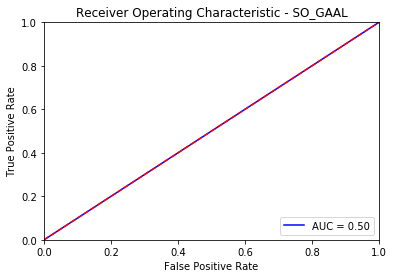

Accuracy:  0.8290666666666666
Precision: -
Recall:  0.0
F1-score: -
Duration:  95.525117  seconds


Epoch 1 of 60

Testing for epoch 1 index 1:


/home/rudda/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:

Testing for epoch 1 index 25:

Testing for epoch 1 index 26:

Testing for epoch 1 index 27:

Testing for epoch 1 index 28:

Testing for epoch 1 index 29:

Testing for epoch 1 index 30:

Testing for epoch 1 index 31:

Testing for epoch 1 index 32:

Testing for epoch 1 index 33:

Testing for epo


Testing for epoch 3 index 25:

Testing for epoch 3 index 26:

Testing for epoch 3 index 27:

Testing for epoch 3 index 28:

Testing for epoch 3 index 29:

Testing for epoch 3 index 30:

Testing for epoch 3 index 31:

Testing for epoch 3 index 32:

Testing for epoch 3 index 33:

Testing for epoch 3 index 34:

Testing for epoch 3 index 35:

Testing for epoch 3 index 36:

Testing for epoch 3 index 37:

Testing for epoch 3 index 38:

Testing for epoch 3 index 39:

Testing for epoch 3 index 40:

Testing for epoch 3 index 41:

Testing for epoch 3 index 42:

Testing for epoch 3 index 43:

Testing for epoch 3 index 44:

Testing for epoch 3 index 45:

Testing for epoch 3 index 46:

Testing for epoch 3 index 47:

Testing for epoch 3 index 48:

Testing for epoch 3 index 49:

Testing for epoch 3 index 50:

Testing for epoch 3 index 51:

Testing for epoch 3 index 52:

Testing for epoch 3 index 53:

Testing for epoch 3 index 54:

Testing for epoch 3 index 55:

Testing for epoch 3 index 56:

Testing


Testing for epoch 5 index 48:

Testing for epoch 5 index 49:

Testing for epoch 5 index 50:

Testing for epoch 5 index 51:

Testing for epoch 5 index 52:

Testing for epoch 5 index 53:

Testing for epoch 5 index 54:

Testing for epoch 5 index 55:

Testing for epoch 5 index 56:

Testing for epoch 5 index 57:

Testing for epoch 5 index 58:

Testing for epoch 5 index 59:

Testing for epoch 5 index 60:

Testing for epoch 5 index 61:

Testing for epoch 5 index 62:

Testing for epoch 5 index 63:

Testing for epoch 5 index 64:

Testing for epoch 5 index 65:

Testing for epoch 5 index 66:

Testing for epoch 5 index 67:

Testing for epoch 5 index 68:

Testing for epoch 5 index 69:

Testing for epoch 5 index 70:

Testing for epoch 5 index 71:

Testing for epoch 5 index 72:

Testing for epoch 5 index 73:

Testing for epoch 5 index 74:

Testing for epoch 5 index 75:

Testing for epoch 5 index 76:

Testing for epoch 5 index 77:

Testing for epoch 5 index 78:

Testing for epoch 5 index 79:

Testing


Testing for epoch 7 index 71:

Testing for epoch 7 index 72:

Testing for epoch 7 index 73:

Testing for epoch 7 index 74:

Testing for epoch 7 index 75:

Testing for epoch 7 index 76:

Testing for epoch 7 index 77:

Testing for epoch 7 index 78:

Testing for epoch 7 index 79:

Testing for epoch 7 index 80:

Testing for epoch 7 index 81:

Testing for epoch 7 index 82:

Testing for epoch 7 index 83:

Testing for epoch 7 index 84:

Testing for epoch 7 index 85:

Testing for epoch 7 index 86:

Testing for epoch 7 index 87:

Testing for epoch 7 index 88:

Testing for epoch 7 index 89:

Testing for epoch 7 index 90:

Testing for epoch 7 index 91:

Testing for epoch 7 index 92:

Testing for epoch 7 index 93:

Testing for epoch 7 index 94:

Testing for epoch 7 index 95:

Testing for epoch 7 index 96:

Testing for epoch 7 index 97:

Testing for epoch 7 index 98:

Testing for epoch 7 index 99:

Testing for epoch 7 index 100:

Testing for epoch 7 index 101:

Testing for epoch 7 index 102:

Test


Testing for epoch 9 index 94:

Testing for epoch 9 index 95:

Testing for epoch 9 index 96:

Testing for epoch 9 index 97:

Testing for epoch 9 index 98:

Testing for epoch 9 index 99:

Testing for epoch 9 index 100:

Testing for epoch 9 index 101:

Testing for epoch 9 index 102:

Testing for epoch 9 index 103:

Testing for epoch 9 index 104:

Testing for epoch 9 index 105:

Testing for epoch 9 index 106:

Testing for epoch 9 index 107:

Testing for epoch 9 index 108:

Testing for epoch 9 index 109:

Testing for epoch 9 index 110:

Testing for epoch 9 index 111:

Testing for epoch 9 index 112:

Testing for epoch 9 index 113:

Testing for epoch 9 index 114:

Testing for epoch 9 index 115:

Testing for epoch 9 index 116:

Testing for epoch 9 index 117:

Testing for epoch 9 index 118:

Testing for epoch 9 index 119:

Testing for epoch 9 index 120:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:

Testing for epoch 10 index 3:

Testing for epoch 10 index 4:

Te


Testing for epoch 11 index 109:

Testing for epoch 11 index 110:

Testing for epoch 11 index 111:

Testing for epoch 11 index 112:

Testing for epoch 11 index 113:

Testing for epoch 11 index 114:

Testing for epoch 11 index 115:

Testing for epoch 11 index 116:

Testing for epoch 11 index 117:

Testing for epoch 11 index 118:

Testing for epoch 11 index 119:

Testing for epoch 11 index 120:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:

Testing for epoch 12 index 3:

Testing for epoch 12 index 4:

Testing for epoch 12 index 5:

Testing for epoch 12 index 6:

Testing for epoch 12 index 7:

Testing for epoch 12 index 8:

Testing for epoch 12 index 9:

Testing for epoch 12 index 10:

Testing for epoch 12 index 11:

Testing for epoch 12 index 12:

Testing for epoch 12 index 13:

Testing for epoch 12 index 14:

Testing for epoch 12 index 15:

Testing for epoch 12 index 16:

Testing for epoch 12 index 17:

Testing for epoch 12 index 18:

Testing for epoch 12 


Testing for epoch 14 index 3:

Testing for epoch 14 index 4:

Testing for epoch 14 index 5:

Testing for epoch 14 index 6:

Testing for epoch 14 index 7:

Testing for epoch 14 index 8:

Testing for epoch 14 index 9:

Testing for epoch 14 index 10:

Testing for epoch 14 index 11:

Testing for epoch 14 index 12:

Testing for epoch 14 index 13:

Testing for epoch 14 index 14:

Testing for epoch 14 index 15:

Testing for epoch 14 index 16:

Testing for epoch 14 index 17:

Testing for epoch 14 index 18:

Testing for epoch 14 index 19:

Testing for epoch 14 index 20:

Testing for epoch 14 index 21:

Testing for epoch 14 index 22:

Testing for epoch 14 index 23:

Testing for epoch 14 index 24:

Testing for epoch 14 index 25:

Testing for epoch 14 index 26:

Testing for epoch 14 index 27:

Testing for epoch 14 index 28:

Testing for epoch 14 index 29:

Testing for epoch 14 index 30:

Testing for epoch 14 index 31:

Testing for epoch 14 index 32:

Testing for epoch 14 index 33:

Testing for ep


Testing for epoch 16 index 18:

Testing for epoch 16 index 19:

Testing for epoch 16 index 20:

Testing for epoch 16 index 21:

Testing for epoch 16 index 22:

Testing for epoch 16 index 23:

Testing for epoch 16 index 24:

Testing for epoch 16 index 25:

Testing for epoch 16 index 26:

Testing for epoch 16 index 27:

Testing for epoch 16 index 28:

Testing for epoch 16 index 29:

Testing for epoch 16 index 30:

Testing for epoch 16 index 31:

Testing for epoch 16 index 32:

Testing for epoch 16 index 33:

Testing for epoch 16 index 34:

Testing for epoch 16 index 35:

Testing for epoch 16 index 36:

Testing for epoch 16 index 37:

Testing for epoch 16 index 38:

Testing for epoch 16 index 39:

Testing for epoch 16 index 40:

Testing for epoch 16 index 41:

Testing for epoch 16 index 42:

Testing for epoch 16 index 43:

Testing for epoch 16 index 44:

Testing for epoch 16 index 45:

Testing for epoch 16 index 46:

Testing for epoch 16 index 47:

Testing for epoch 16 index 48:

Testing


Testing for epoch 18 index 33:

Testing for epoch 18 index 34:

Testing for epoch 18 index 35:

Testing for epoch 18 index 36:

Testing for epoch 18 index 37:

Testing for epoch 18 index 38:

Testing for epoch 18 index 39:

Testing for epoch 18 index 40:

Testing for epoch 18 index 41:

Testing for epoch 18 index 42:

Testing for epoch 18 index 43:

Testing for epoch 18 index 44:

Testing for epoch 18 index 45:

Testing for epoch 18 index 46:

Testing for epoch 18 index 47:

Testing for epoch 18 index 48:

Testing for epoch 18 index 49:

Testing for epoch 18 index 50:

Testing for epoch 18 index 51:

Testing for epoch 18 index 52:

Testing for epoch 18 index 53:

Testing for epoch 18 index 54:

Testing for epoch 18 index 55:

Testing for epoch 18 index 56:

Testing for epoch 18 index 57:

Testing for epoch 18 index 58:

Testing for epoch 18 index 59:

Testing for epoch 18 index 60:

Testing for epoch 18 index 61:

Testing for epoch 18 index 62:

Testing for epoch 18 index 63:

Testing


Testing for epoch 20 index 48:

Testing for epoch 20 index 49:

Testing for epoch 20 index 50:

Testing for epoch 20 index 51:

Testing for epoch 20 index 52:

Testing for epoch 20 index 53:

Testing for epoch 20 index 54:

Testing for epoch 20 index 55:

Testing for epoch 20 index 56:

Testing for epoch 20 index 57:

Testing for epoch 20 index 58:

Testing for epoch 20 index 59:

Testing for epoch 20 index 60:

Testing for epoch 20 index 61:

Testing for epoch 20 index 62:

Testing for epoch 20 index 63:

Testing for epoch 20 index 64:

Testing for epoch 20 index 65:

Testing for epoch 20 index 66:

Testing for epoch 20 index 67:

Testing for epoch 20 index 68:

Testing for epoch 20 index 69:

Testing for epoch 20 index 70:

Testing for epoch 20 index 71:

Testing for epoch 20 index 72:

Testing for epoch 20 index 73:

Testing for epoch 20 index 74:

Testing for epoch 20 index 75:

Testing for epoch 20 index 76:

Testing for epoch 20 index 77:

Testing for epoch 20 index 78:

Testing

500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 26:
500/500 [==============================] - 0s 15us/step

Testing for epoch 21 index 27:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 28:
500/500 [==============================] - 0s 15us/step

Testing for epoch 21 index 29:
500/500 [==============================] - 0s 16us/step

Testing for epoch 21 index 30:
500/500 [==============================] - 0s 21us/step

Testing for epoch 21 index 31:
500/500 [==============================] - 0s 15us/step

Testing for epoch 21 index 32:
500/500 [==============================] - 0s 16us/step

Testing for epoch 21 index 33:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 34:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 35:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 36:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 54:
500/500 [==============================] - 0s 17us/step

Testing for epoch 21 index 55:
500/500 [==============================] - 0s 15us/step

Testing for epoch 21 index 56:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 57:
500/500 [==============================] - 0s 15us/step

Testing for epoch 21 index 58:
500/500 [==============================] - 0s 15us/step

Testing for epoch 21 index 59:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 60:
500/500 [==============================] - 0s 16us/step

Testing for epoch 21 index 61:
500/500 [==============================] - 0s 16us/step

Testing for epoch 21 index 62:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 63:
500/500 [==============================] - 0s 15us/step

Testing for epoch 21 index 64:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 81:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 82:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 83:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 84:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 85:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 86:
500/500 [==============================] - 0s 21us/step

Testing for epoch 21 index 87:
500/500 [==============================] - 0s 16us/step

Testing for epoch 21 index 88:
500/500 [==============================] - 0s 16us/step

Testing for epoch 21 index 89:
500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 90:
500/500 [==============================] - 0s 17us/step

Testing for epoch 21 index 91:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 21 index 109:
500/500 [==============================] - 0s 16us/step

Testing for epoch 21 index 110:
500/500 [==============================] - 0s 20us/step

Testing for epoch 21 index 111:
500/500 [==============================] - 0s 32us/step

Testing for epoch 21 index 112:
500/500 [==============================] - 0s 19us/step

Testing for epoch 21 index 113:
500/500 [==============================] - 0s 16us/step

Testing for epoch 21 index 114:
500/500 [==============================] - 0s 17us/step

Testing for epoch 21 index 115:
500/500 [==============================] - 0s 18us/step

Testing for epoch 21 index 116:
500/500 [==============================] - 0s 16us/step

Testing for epoch 21 index 117:
500/500 [==============================] - 0s 15us/step

Testing for epoch 21 index 118:
500/500 [==============================] - 0s 16us/step

Testing for epoch 21 index 119:
500/500 [============

500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 16:
500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 17:
500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 18:
500/500 [==============================] - 0s 17us/step

Testing for epoch 22 index 19:
500/500 [==============================] - 0s 14us/step

Testing for epoch 22 index 20:
500/500 [==============================] - 0s 21us/step

Testing for epoch 22 index 21:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 22:
500/500 [==============================] - 0s 45us/step

Testing for epoch 22 index 23:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 24:
500/500 [==============================] - 0s 18us/step

Testing for epoch 22 index 25:
500/500 [==============================] - 0s 35us/step

Testing for epoch 22 index 26:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 44:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 45:
500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 46:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 47:
500/500 [==============================] - 0s 17us/step

Testing for epoch 22 index 48:
500/500 [==============================] - 0s 17us/step

Testing for epoch 22 index 49:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 50:
500/500 [==============================] - 0s 18us/step

Testing for epoch 22 index 51:
500/500 [==============================] - 0s 19us/step

Testing for epoch 22 index 52:
500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 53:
500/500 [==============================] - 0s 17us/step

Testing for epoch 22 index 54:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 72:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 73:
500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 74:
500/500 [==============================] - 0s 17us/step

Testing for epoch 22 index 75:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 76:
500/500 [==============================] - 0s 18us/step

Testing for epoch 22 index 77:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 78:
500/500 [==============================] - 0s 17us/step

Testing for epoch 22 index 79:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 80:
500/500 [==============================] - 0s 18us/step

Testing for epoch 22 index 81:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 82:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 99:
500/500 [==============================] - 0s 15us/step

Testing for epoch 22 index 100:
500/500 [==============================] - 0s 17us/step

Testing for epoch 22 index 101:
500/500 [==============================] - 0s 18us/step

Testing for epoch 22 index 102:
500/500 [==============================] - 0s 17us/step

Testing for epoch 22 index 103:
500/500 [==============================] - 0s 17us/step

Testing for epoch 22 index 104:
500/500 [==============================] - 0s 18us/step

Testing for epoch 22 index 105:
500/500 [==============================] - 0s 17us/step

Testing for epoch 22 index 106:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 107:
500/500 [==============================] - 0s 18us/step

Testing for epoch 22 index 108:
500/500 [==============================] - 0s 16us/step

Testing for epoch 22 index 109:
500/500 [=============

500/500 [==============================] - 0s 19us/step

Testing for epoch 23 index 7:
500/500 [==============================] - 0s 16us/step

Testing for epoch 23 index 8:
500/500 [==============================] - 0s 14us/step

Testing for epoch 23 index 9:
500/500 [==============================] - 0s 15us/step

Testing for epoch 23 index 10:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 11:
500/500 [==============================] - 0s 18us/step

Testing for epoch 23 index 12:
500/500 [==============================] - 0s 20us/step

Testing for epoch 23 index 13:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 14:
500/500 [==============================] - 0s 15us/step

Testing for epoch 23 index 15:
500/500 [==============================] - 0s 18us/step

Testing for epoch 23 index 16:
500/500 [==============================] - 0s 15us/step

Testing for epoch 23 index 17:
500/500 [==========================

500/500 [==============================] - 0s 16us/step

Testing for epoch 23 index 34:
500/500 [==============================] - 0s 16us/step

Testing for epoch 23 index 35:
500/500 [==============================] - 0s 18us/step

Testing for epoch 23 index 36:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 37:
500/500 [==============================] - 0s 16us/step

Testing for epoch 23 index 38:
500/500 [==============================] - 0s 16us/step

Testing for epoch 23 index 39:
500/500 [==============================] - 0s 15us/step

Testing for epoch 23 index 40:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 41:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 42:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 43:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 44:
500/500 [=======================

500/500 [==============================] - 0s 18us/step

Testing for epoch 23 index 62:
500/500 [==============================] - 0s 16us/step

Testing for epoch 23 index 63:
500/500 [==============================] - 0s 19us/step

Testing for epoch 23 index 64:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 65:
500/500 [==============================] - 0s 16us/step

Testing for epoch 23 index 66:
500/500 [==============================] - 0s 18us/step

Testing for epoch 23 index 67:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 68:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 69:
500/500 [==============================] - 0s 13us/step

Testing for epoch 23 index 70:
500/500 [==============================] - 0s 18us/step

Testing for epoch 23 index 71:
500/500 [==============================] - 0s 18us/step

Testing for epoch 23 index 72:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 90:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 91:
500/500 [==============================] - 0s 36us/step

Testing for epoch 23 index 92:
500/500 [==============================] - 0s 16us/step

Testing for epoch 23 index 93:
500/500 [==============================] - 0s 16us/step

Testing for epoch 23 index 94:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 95:
500/500 [==============================] - 0s 19us/step

Testing for epoch 23 index 96:
500/500 [==============================] - 0s 30us/step

Testing for epoch 23 index 97:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 98:
500/500 [==============================] - 0s 27us/step

Testing for epoch 23 index 99:
500/500 [==============================] - 0s 18us/step

Testing for epoch 23 index 100:
500/500 [======================

500/500 [==============================] - 0s 18us/step

Testing for epoch 23 index 117:
500/500 [==============================] - 0s 39us/step

Testing for epoch 23 index 118:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 119:
500/500 [==============================] - 0s 31us/step

Testing for epoch 23 index 120:
500/500 [==============================] - 0s 16us/step
Epoch 24 of 60

Testing for epoch 24 index 1:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 24 index 3:
500/500 [==============================] - 0s 18us/step

Testing for epoch 24 index 4:
500/500 [==============================] - 0s 14us/step

Testing for epoch 24 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 24 index 6:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 7:
500/500 [===========

500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 25:
500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 26:
500/500 [==============================] - 0s 15us/step

Testing for epoch 24 index 27:
500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 28:
500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 29:
500/500 [==============================] - 0s 18us/step

Testing for epoch 24 index 30:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 31:
500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 32:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 33:
500/500 [==============================] - 0s 35us/step

Testing for epoch 24 index 34:
500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 35:
500/500 [=======================

500/500 [==============================] - 0s 19us/step

Testing for epoch 24 index 52:
500/500 [==============================] - 0s 15us/step

Testing for epoch 24 index 53:
500/500 [==============================] - 0s 14us/step

Testing for epoch 24 index 54:
500/500 [==============================] - 0s 14us/step

Testing for epoch 24 index 55:
500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 56:
500/500 [==============================] - 0s 49us/step

Testing for epoch 24 index 57:
500/500 [==============================] - 0s 22us/step

Testing for epoch 24 index 58:
500/500 [==============================] - 0s 15us/step

Testing for epoch 24 index 59:
500/500 [==============================] - 0s 13us/step

Testing for epoch 24 index 60:
500/500 [==============================] - 0s 15us/step

Testing for epoch 24 index 61:
500/500 [==============================] - 0s 14us/step

Testing for epoch 24 index 62:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 80:
500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 81:
500/500 [==============================] - 0s 15us/step

Testing for epoch 24 index 82:
500/500 [==============================] - 0s 15us/step

Testing for epoch 24 index 83:
500/500 [==============================] - 0s 14us/step

Testing for epoch 24 index 84:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 85:
500/500 [==============================] - 0s 15us/step

Testing for epoch 24 index 86:
500/500 [==============================] - 0s 14us/step

Testing for epoch 24 index 87:
500/500 [==============================] - 0s 14us/step

Testing for epoch 24 index 88:
500/500 [==============================] - 0s 15us/step

Testing for epoch 24 index 89:
500/500 [==============================] - 0s 14us/step

Testing for epoch 24 index 90:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 108:
500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 109:
500/500 [==============================] - 0s 29us/step

Testing for epoch 24 index 110:
500/500 [==============================] - 0s 18us/step

Testing for epoch 24 index 111:
500/500 [==============================] - 0s 19us/step

Testing for epoch 24 index 112:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 113:
500/500 [==============================] - 0s 20us/step

Testing for epoch 24 index 114:
500/500 [==============================] - 0s 23us/step

Testing for epoch 24 index 115:
500/500 [==============================] - 0s 52us/step

Testing for epoch 24 index 116:
500/500 [==============================] - 0s 13us/step

Testing for epoch 24 index 117:
500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 118:
500/500 [============

500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 15:
500/500 [==============================] - 0s 13us/step

Testing for epoch 25 index 16:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 17:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 18:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 19:
500/500 [==============================] - 0s 13us/step

Testing for epoch 25 index 20:
500/500 [==============================] - 0s 14us/step

Testing for epoch 25 index 21:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 22:
500/500 [==============================] - 0s 14us/step

Testing for epoch 25 index 23:
500/500 [==============================] - 0s 14us/step

Testing for epoch 25 index 24:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 25:
500/500 [=======================

500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 43:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 44:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 45:
500/500 [==============================] - 0s 19us/step

Testing for epoch 25 index 46:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 47:
500/500 [==============================] - 0s 19us/step

Testing for epoch 25 index 48:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 49:
500/500 [==============================] - 0s 19us/step

Testing for epoch 25 index 50:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 51:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 52:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 53:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 25 index 70:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 71:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 72:
500/500 [==============================] - 0s 18us/step

Testing for epoch 25 index 73:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 74:
500/500 [==============================] - 0s 32us/step

Testing for epoch 25 index 75:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 76:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 77:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 78:
500/500 [==============================] - 0s 35us/step

Testing for epoch 25 index 79:
500/500 [==============================] - 0s 18us/step

Testing for epoch 25 index 80:
500/500 [=======================

500/500 [==============================] - 0s 19us/step

Testing for epoch 25 index 98:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 99:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 100:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 101:
500/500 [==============================] - 0s 18us/step

Testing for epoch 25 index 102:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 103:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 104:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 105:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 106:
500/500 [==============================] - 0s 14us/step

Testing for epoch 25 index 107:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 108:
500/500 [==============

500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 6:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 7:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 9:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 10:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 11:
500/500 [==============================] - 0s 14us/step

Testing for epoch 26 index 12:
500/500 [==============================] - 0s 19us/step

Testing for epoch 26 index 13:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 14:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 15:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 16:
500/500 [===========================


Testing for epoch 26 index 19:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 20:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 21:
500/500 [==============================] - 0s 52us/step

Testing for epoch 26 index 22:
500/500 [==============================] - 0s 35us/step

Testing for epoch 26 index 23:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 24:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 25:
500/500 [==============================] - 0s 14us/step

Testing for epoch 26 index 26:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 27:
500/500 [==============================] - 0s 19us/step

Testing for epoch 26 index 28:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 29:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 30:


500/500 [==============================] - 0s 20us/step

Testing for epoch 26 index 47:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 48:
500/500 [==============================] - 0s 19us/step

Testing for epoch 26 index 49:
500/500 [==============================] - 0s 14us/step

Testing for epoch 26 index 50:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 51:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 52:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 53:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 54:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 55:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 56:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 57:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 75:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 76:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 77:
500/500 [==============================] - 0s 14us/step

Testing for epoch 26 index 78:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 79:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 80:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 81:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 82:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 83:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 84:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 85:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 26 index 102:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 103:
500/500 [==============================] - 0s 19us/step

Testing for epoch 26 index 104:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 105:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 106:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 107:
500/500 [==============================] - 0s 17us/step

Testing for epoch 26 index 108:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 109:
500/500 [==============================] - 0s 19us/step

Testing for epoch 26 index 110:
500/500 [==============================] - 0s 18us/step

Testing for epoch 26 index 111:
500/500 [==============================] - 0s 27us/step

Testing for epoch 26 index 112:
500/500 [============

500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 10:
500/500 [==============================] - 0s 20us/step

Testing for epoch 27 index 11:
500/500 [==============================] - 0s 18us/step

Testing for epoch 27 index 12:
500/500 [==============================] - 0s 18us/step

Testing for epoch 27 index 13:
500/500 [==============================] - 0s 15us/step

Testing for epoch 27 index 14:
500/500 [==============================] - 0s 17us/step

Testing for epoch 27 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 27 index 16:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 17:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 18:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 19:
500/500 [==============================] - 0s 15us/step

Testing for epoch 27 index 20:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 38:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 39:
500/500 [==============================] - 0s 17us/step

Testing for epoch 27 index 40:
500/500 [==============================] - 0s 17us/step

Testing for epoch 27 index 41:
500/500 [==============================] - 0s 17us/step

Testing for epoch 27 index 42:
500/500 [==============================] - 0s 18us/step

Testing for epoch 27 index 43:
500/500 [==============================] - 0s 18us/step

Testing for epoch 27 index 44:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 45:
500/500 [==============================] - 0s 19us/step

Testing for epoch 27 index 46:
500/500 [==============================] - 0s 18us/step

Testing for epoch 27 index 47:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 48:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 65:
500/500 [==============================] - 0s 18us/step

Testing for epoch 27 index 66:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 67:
500/500 [==============================] - 0s 18us/step

Testing for epoch 27 index 68:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 69:
500/500 [==============================] - 0s 17us/step

Testing for epoch 27 index 70:
500/500 [==============================] - 0s 17us/step

Testing for epoch 27 index 71:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 72:
500/500 [==============================] - 0s 18us/step

Testing for epoch 27 index 73:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 74:
500/500 [==============================] - 0s 19us/step

Testing for epoch 27 index 75:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 27 index 93:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 94:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 95:
500/500 [==============================] - 0s 17us/step

Testing for epoch 27 index 96:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 97:
500/500 [==============================] - 0s 18us/step

Testing for epoch 27 index 98:
500/500 [==============================] - 0s 15us/step

Testing for epoch 27 index 99:
500/500 [==============================] - 0s 17us/step

Testing for epoch 27 index 100:
500/500 [==============================] - 0s 16us/step

Testing for epoch 27 index 101:
500/500 [==============================] - 0s 15us/step

Testing for epoch 27 index 102:
500/500 [==============================] - 0s 18us/step

Testing for epoch 27 index 103:
500/500 [===================

500/500 [==============================] - 0s 17us/step

Testing for epoch 27 index 120:
500/500 [==============================] - 0s 15us/step
Epoch 28 of 60

Testing for epoch 28 index 1:
500/500 [==============================] - 0s 20us/step

Testing for epoch 28 index 2:
500/500 [==============================] - 0s 14us/step

Testing for epoch 28 index 3:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 4:
500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 5:
500/500 [==============================] - 0s 19us/step

Testing for epoch 28 index 6:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 7:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 9:
500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 10:
500/500 [================

500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 28:
500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 29:
500/500 [==============================] - 0s 24us/step

Testing for epoch 28 index 30:
500/500 [==============================] - 0s 19us/step

Testing for epoch 28 index 31:
500/500 [==============================] - 0s 15us/step

Testing for epoch 28 index 32:
500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 33:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 34:
500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 35:
500/500 [==============================] - 0s 19us/step

Testing for epoch 28 index 36:
500/500 [==============================] - 0s 20us/step

Testing for epoch 28 index 37:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 38:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 56:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 57:
500/500 [==============================] - 0s 15us/step

Testing for epoch 28 index 58:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 59:
500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 60:
500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 61:
500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 62:
500/500 [==============================] - 0s 28us/step

Testing for epoch 28 index 63:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 64:
500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 65:
500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 66:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 83:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 84:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 85:
500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 86:
500/500 [==============================] - 0s 14us/step

Testing for epoch 28 index 87:
500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 88:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 89:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 90:
500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 91:
500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 92:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 93:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 111:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 112:
500/500 [==============================] - 0s 20us/step

Testing for epoch 28 index 113:
500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 114:
500/500 [==============================] - 0s 16us/step

Testing for epoch 28 index 115:
500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 116:
500/500 [==============================] - 0s 15us/step

Testing for epoch 28 index 117:
500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 118:
500/500 [==============================] - 0s 17us/step

Testing for epoch 28 index 119:
500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 120:
500/500 [==============================] - 0s 18us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
500/500 

500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 5:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 6:
500/500 [==============================] - 0s 18us/step

Testing for epoch 29 index 7:
500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 9:
500/500 [==============================] - 0s 18us/step

Testing for epoch 29 index 10:
500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 11:
500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 12:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 13:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 14:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 15:
500/500 [============================

500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 18:
500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 19:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 20:
500/500 [==============================] - 0s 18us/step

Testing for epoch 29 index 21:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 22:
500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 23:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 24:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 25:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 26:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 27:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 28:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 46:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 47:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 48:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 49:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 50:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 51:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 52:
500/500 [==============================] - 0s 18us/step

Testing for epoch 29 index 53:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 54:
500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 55:
500/500 [==============================] - 0s 14us/step

Testing for epoch 29 index 56:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 74:
500/500 [==============================] - 0s 14us/step

Testing for epoch 29 index 75:
500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 76:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 77:
500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 78:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 79:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 80:
500/500 [==============================] - 0s 18us/step

Testing for epoch 29 index 81:
500/500 [==============================] - 0s 18us/step

Testing for epoch 29 index 82:
500/500 [==============================] - 0s 19us/step

Testing for epoch 29 index 83:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 84:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 101:
500/500 [==============================] - 0s 18us/step

Testing for epoch 29 index 102:
500/500 [==============================] - 0s 17us/step

Testing for epoch 29 index 103:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 104:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 105:
500/500 [==============================] - 0s 19us/step

Testing for epoch 29 index 106:
500/500 [==============================] - 0s 19us/step

Testing for epoch 29 index 107:
500/500 [==============================] - 0s 19us/step

Testing for epoch 29 index 108:
500/500 [==============================] - 0s 15us/step

Testing for epoch 29 index 109:
500/500 [==============================] - 0s 19us/step

Testing for epoch 29 index 110:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 111:
500/500 [============

500/500 [==============================] - 0s 18us/step

Testing for epoch 30 index 9:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 10:
500/500 [==============================] - 0s 18us/step

Testing for epoch 30 index 11:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 12:
500/500 [==============================] - 0s 16us/step

Testing for epoch 30 index 13:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 14:
500/500 [==============================] - 0s 18us/step

Testing for epoch 30 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 30 index 16:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 17:
500/500 [==============================] - 0s 20us/step

Testing for epoch 30 index 18:
500/500 [==============================] - 0s 20us/step

Testing for epoch 30 index 19:
500/500 [========================

500/500 [==============================] - 0s 16us/step

Testing for epoch 30 index 36:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 37:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 38:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 39:
500/500 [==============================] - 0s 16us/step

Testing for epoch 30 index 40:
500/500 [==============================] - 0s 18us/step

Testing for epoch 30 index 41:
500/500 [==============================] - 0s 16us/step

Testing for epoch 30 index 42:
500/500 [==============================] - 0s 16us/step

Testing for epoch 30 index 43:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 44:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 45:
500/500 [==============================] - 0s 16us/step

Testing for epoch 30 index 46:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 64:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 65:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 66:
500/500 [==============================] - 0s 14us/step

Testing for epoch 30 index 67:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 68:
500/500 [==============================] - 0s 19us/step

Testing for epoch 30 index 69:
500/500 [==============================] - 0s 16us/step

Testing for epoch 30 index 70:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 71:
500/500 [==============================] - 0s 18us/step

Testing for epoch 30 index 72:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 73:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 74:
500/500 [=======================

500/500 [==============================] - 0s 19us/step

Testing for epoch 30 index 92:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 93:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 94:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 95:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 96:
500/500 [==============================] - 0s 16us/step

Testing for epoch 30 index 97:
500/500 [==============================] - 0s 15us/step

Testing for epoch 30 index 98:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 99:
500/500 [==============================] - 0s 16us/step

Testing for epoch 30 index 100:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 101:
500/500 [==============================] - 0s 18us/step

Testing for epoch 30 index 102:
500/500 [====================

500/500 [==============================] - 0s 19us/step

Testing for epoch 30 index 119:
500/500 [==============================] - 0s 17us/step

Testing for epoch 30 index 120:
500/500 [==============================] - 0s 14us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 2:
500/500 [==============================] - 0s 23us/step

Testing for epoch 31 index 3:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 4:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 5:
500/500 [==============================] - 0s 19us/step

Testing for epoch 31 index 6:
500/500 [==============================] - 0s 16us/step

Testing for epoch 31 index 7:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 31 index 9:
500/500 [===============

500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 27:
500/500 [==============================] - 0s 16us/step

Testing for epoch 31 index 28:
500/500 [==============================] - 0s 16us/step

Testing for epoch 31 index 29:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 30:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 31:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 32:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 33:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 34:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 35:
500/500 [==============================] - 0s 19us/step

Testing for epoch 31 index 36:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 37:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 54:
500/500 [==============================] - 0s 16us/step

Testing for epoch 31 index 55:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 56:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 57:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 58:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 59:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 60:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 61:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 62:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 63:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 64:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 31 index 82:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 83:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 84:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 85:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 86:
500/500 [==============================] - 0s 19us/step

Testing for epoch 31 index 87:
500/500 [==============================] - 0s 16us/step

Testing for epoch 31 index 88:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 89:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 90:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 91:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 92:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 110:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 111:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 112:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 113:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 114:
500/500 [==============================] - 0s 19us/step

Testing for epoch 31 index 115:
500/500 [==============================] - 0s 16us/step

Testing for epoch 31 index 116:
500/500 [==============================] - 0s 17us/step

Testing for epoch 31 index 117:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 118:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 119:
500/500 [==============================] - 0s 18us/step

Testing for epoch 31 index 120:
500/500 [============

500/500 [==============================] - 0s 19us/step

Testing for epoch 32 index 17:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 18:
500/500 [==============================] - 0s 17us/step

Testing for epoch 32 index 19:
500/500 [==============================] - 0s 17us/step

Testing for epoch 32 index 20:
500/500 [==============================] - 0s 18us/step

Testing for epoch 32 index 21:
500/500 [==============================] - 0s 18us/step

Testing for epoch 32 index 22:
500/500 [==============================] - 0s 23us/step

Testing for epoch 32 index 23:
500/500 [==============================] - 0s 13us/step

Testing for epoch 32 index 24:
500/500 [==============================] - 0s 18us/step

Testing for epoch 32 index 25:
500/500 [==============================] - 0s 17us/step

Testing for epoch 32 index 26:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 27:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 32 index 45:
500/500 [==============================] - 0s 18us/step

Testing for epoch 32 index 46:
500/500 [==============================] - 0s 17us/step

Testing for epoch 32 index 47:
500/500 [==============================] - 0s 16us/step

Testing for epoch 32 index 48:
500/500 [==============================] - 0s 16us/step

Testing for epoch 32 index 49:
500/500 [==============================] - 0s 22us/step

Testing for epoch 32 index 50:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 51:
500/500 [==============================] - 0s 20us/step

Testing for epoch 32 index 52:
500/500 [==============================] - 0s 17us/step

Testing for epoch 32 index 53:
500/500 [==============================] - 0s 16us/step

Testing for epoch 32 index 54:
500/500 [==============================] - 0s 19us/step

Testing for epoch 32 index 55:
500/500 [=======================

500/500 [==============================] - 0s 18us/step

Testing for epoch 32 index 72:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 73:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 74:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 75:
500/500 [==============================] - 0s 19us/step

Testing for epoch 32 index 76:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 77:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 78:
500/500 [==============================] - 0s 16us/step

Testing for epoch 32 index 79:
500/500 [==============================] - 0s 16us/step

Testing for epoch 32 index 80:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 81:
500/500 [==============================] - 0s 17us/step

Testing for epoch 32 index 82:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 32 index 100:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 101:
500/500 [==============================] - 0s 16us/step

Testing for epoch 32 index 102:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 103:
500/500 [==============================] - 0s 24us/step

Testing for epoch 32 index 104:
500/500 [==============================] - 0s 18us/step

Testing for epoch 32 index 105:
500/500 [==============================] - 0s 16us/step

Testing for epoch 32 index 106:
500/500 [==============================] - 0s 18us/step

Testing for epoch 32 index 107:
500/500 [==============================] - 0s 16us/step

Testing for epoch 32 index 108:
500/500 [==============================] - 0s 20us/step

Testing for epoch 32 index 109:
500/500 [==============================] - 0s 18us/step

Testing for epoch 32 index 110:
500/500 [============

500/500 [==============================] - 0s 16us/step

Testing for epoch 33 index 8:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 9:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 10:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 11:
500/500 [==============================] - 0s 17us/step

Testing for epoch 33 index 12:
500/500 [==============================] - 0s 17us/step

Testing for epoch 33 index 13:
500/500 [==============================] - 0s 16us/step

Testing for epoch 33 index 14:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 16:
500/500 [==============================] - 0s 18us/step

Testing for epoch 33 index 17:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 18:
500/500 [=========================


Testing for epoch 33 index 21:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 22:
500/500 [==============================] - 0s 17us/step

Testing for epoch 33 index 23:
500/500 [==============================] - 0s 16us/step

Testing for epoch 33 index 24:
500/500 [==============================] - 0s 17us/step

Testing for epoch 33 index 25:
500/500 [==============================] - 0s 17us/step

Testing for epoch 33 index 26:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 27:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 28:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 29:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 30:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 31:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 32:


500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 49:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 50:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 51:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 52:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 53:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 54:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 55:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 56:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 57:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 58:
500/500 [==============================] - 0s 17us/step

Testing for epoch 33 index 59:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 77:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 78:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 79:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 80:
500/500 [==============================] - 0s 19us/step

Testing for epoch 33 index 81:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 82:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 83:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 84:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 85:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 86:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 87:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 104:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 105:
500/500 [==============================] - 0s 16us/step

Testing for epoch 33 index 106:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 107:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 108:
500/500 [==============================] - 0s 14us/step

Testing for epoch 33 index 109:
500/500 [==============================] - 0s 13us/step

Testing for epoch 33 index 110:
500/500 [==============================] - 0s 17us/step

Testing for epoch 33 index 111:
500/500 [==============================] - 0s 16us/step

Testing for epoch 33 index 112:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 113:
500/500 [==============================] - 0s 15us/step

Testing for epoch 33 index 114:
500/500 [============

500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 12:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 13:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 14:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 15:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 16:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 17:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 18:
500/500 [==============================] - 0s 17us/step

Testing for epoch 34 index 19:
500/500 [==============================] - 0s 17us/step

Testing for epoch 34 index 20:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 21:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 22:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 40:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 41:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 42:
500/500 [==============================] - 0s 18us/step

Testing for epoch 34 index 43:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 44:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 45:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 46:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 47:
500/500 [==============================] - 0s 16us/step

Testing for epoch 34 index 48:
500/500 [==============================] - 0s 16us/step

Testing for epoch 34 index 49:
500/500 [==============================] - 0s 16us/step

Testing for epoch 34 index 50:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 67:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 68:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 69:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 70:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 71:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 72:
500/500 [==============================] - 0s 19us/step

Testing for epoch 34 index 73:
500/500 [==============================] - 0s 16us/step

Testing for epoch 34 index 74:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 75:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 76:
500/500 [==============================] - 0s 16us/step

Testing for epoch 34 index 77:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 34 index 95:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 96:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 97:
500/500 [==============================] - 0s 13us/step

Testing for epoch 34 index 98:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 99:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 100:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 101:
500/500 [==============================] - 0s 16us/step

Testing for epoch 34 index 102:
500/500 [==============================] - 0s 16us/step

Testing for epoch 34 index 103:
500/500 [==============================] - 0s 14us/step

Testing for epoch 34 index 104:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 105:
500/500 [=================

500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 2:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 3:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 4:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 5:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 6:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 7:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 8:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 9:
500/500 [==============================] - 0s 17us/step

Testing for epoch 35 index 10:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 11:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 12:
500/500 [==============================]

500/500 [==============================] - 0s 16us/step

Testing for epoch 35 index 30:
500/500 [==============================] - 0s 16us/step

Testing for epoch 35 index 31:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 32:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 33:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 34:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 35:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 36:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 37:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 38:
500/500 [==============================] - 0s 16us/step

Testing for epoch 35 index 39:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 40:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 58:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 59:
500/500 [==============================] - 0s 16us/step

Testing for epoch 35 index 60:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 61:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 62:
500/500 [==============================] - 0s 13us/step

Testing for epoch 35 index 63:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 64:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 65:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 66:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 67:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 68:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 85:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 86:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 87:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 88:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 89:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 90:
500/500 [==============================] - 0s 16us/step

Testing for epoch 35 index 91:
500/500 [==============================] - 0s 16us/step

Testing for epoch 35 index 92:
500/500 [==============================] - 0s 16us/step

Testing for epoch 35 index 93:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 94:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 95:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 113:
500/500 [==============================] - 0s 16us/step

Testing for epoch 35 index 114:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 115:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 116:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 117:
500/500 [==============================] - 0s 16us/step

Testing for epoch 35 index 118:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 119:
500/500 [==============================] - 0s 14us/step

Testing for epoch 35 index 120:
500/500 [==============================] - 0s 14us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 2:
500/500 [==============================] - 0s 16us/step

Testing for epoch 36 index 3:
500/500 [===

500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 7:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 8:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 9:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 10:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 11:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 12:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 13:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 14:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 16:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 17:
500/500 [==========================

500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 20:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 21:
500/500 [==============================] - 0s 16us/step

Testing for epoch 36 index 22:
500/500 [==============================] - 0s 16us/step

Testing for epoch 36 index 23:
500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 24:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 25:
500/500 [==============================] - 0s 18us/step

Testing for epoch 36 index 26:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 27:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 28:
500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 29:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 30:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 48:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 49:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 50:
500/500 [==============================] - 0s 16us/step

Testing for epoch 36 index 51:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 52:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 53:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 54:
500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 55:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 56:
500/500 [==============================] - 0s 11us/step

Testing for epoch 36 index 57:
500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 58:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 76:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 77:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 78:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 79:
500/500 [==============================] - 0s 23us/step

Testing for epoch 36 index 80:
500/500 [==============================] - 0s 17us/step

Testing for epoch 36 index 81:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 82:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 83:
500/500 [==============================] - 0s 16us/step

Testing for epoch 36 index 84:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 85:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 86:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 36 index 103:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 104:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 105:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 106:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 107:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 108:
500/500 [==============================] - 0s 17us/step

Testing for epoch 36 index 109:
500/500 [==============================] - 0s 15us/step

Testing for epoch 36 index 110:
500/500 [==============================] - 0s 17us/step

Testing for epoch 36 index 111:
500/500 [==============================] - 0s 13us/step

Testing for epoch 36 index 112:
500/500 [==============================] - 0s 14us/step

Testing for epoch 36 index 113:
500/500 [============

500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 11:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 12:
500/500 [==============================] - 0s 13us/step

Testing for epoch 37 index 13:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 14:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 16:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 17:
500/500 [==============================] - 0s 18us/step

Testing for epoch 37 index 18:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 19:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 20:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 21:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 37 index 38:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 39:
500/500 [==============================] - 0s 16us/step

Testing for epoch 37 index 40:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 41:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 42:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 43:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 44:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 45:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 46:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 47:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 48:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 66:
500/500 [==============================] - 0s 16us/step

Testing for epoch 37 index 67:
500/500 [==============================] - 0s 13us/step

Testing for epoch 37 index 68:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 69:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 70:
500/500 [==============================] - 0s 13us/step

Testing for epoch 37 index 71:
500/500 [==============================] - 0s 13us/step

Testing for epoch 37 index 72:
500/500 [==============================] - 0s 17us/step

Testing for epoch 37 index 73:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 74:
500/500 [==============================] - 0s 16us/step

Testing for epoch 37 index 75:
500/500 [==============================] - 0s 13us/step

Testing for epoch 37 index 76:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 94:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 95:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 96:
500/500 [==============================] - 0s 16us/step

Testing for epoch 37 index 97:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 98:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 99:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 100:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 101:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 102:
500/500 [==============================] - 0s 16us/step

Testing for epoch 37 index 103:
500/500 [==============================] - 0s 14us/step

Testing for epoch 37 index 104:
500/500 [==================

500/500 [==============================] - 0s 14us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
500/500 [==============================] - 0s 13us/step

Testing for epoch 38 index 2:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 3:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 4:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 5:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 6:
500/500 [==============================] - 0s 13us/step

Testing for epoch 38 index 7:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 8:
500/500 [==============================] - 0s 13us/step

Testing for epoch 38 index 9:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 10:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 11:
500/500 [=================

500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 29:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 30:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 31:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 32:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 33:
500/500 [==============================] - 0s 13us/step

Testing for epoch 38 index 34:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 35:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 36:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 37:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 38:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 39:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 56:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 57:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 58:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 59:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 60:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 61:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 62:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 63:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 64:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 65:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 66:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 38 index 84:
500/500 [==============================] - 0s 12us/step

Testing for epoch 38 index 85:
500/500 [==============================] - 0s 17us/step

Testing for epoch 38 index 86:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 87:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 88:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 89:
500/500 [==============================] - 0s 17us/step

Testing for epoch 38 index 90:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 91:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 92:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 93:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 94:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 112:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 113:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 114:
500/500 [==============================] - 0s 15us/step

Testing for epoch 38 index 115:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 116:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 117:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 118:
500/500 [==============================] - 0s 13us/step

Testing for epoch 38 index 119:
500/500 [==============================] - 0s 14us/step

Testing for epoch 38 index 120:
500/500 [==============================] - 0s 16us/step
Epoch 39 of 60

Testing for epoch 39 index 1:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 2:
500/500 [=

500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 19:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 20:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 21:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 22:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 23:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 24:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 25:
500/500 [==============================] - 0s 16us/step

Testing for epoch 39 index 26:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 27:
500/500 [==============================] - 0s 17us/step

Testing for epoch 39 index 28:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 29:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 47:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 48:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 49:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 50:
500/500 [==============================] - 0s 13us/step

Testing for epoch 39 index 51:
500/500 [==============================] - 0s 16us/step

Testing for epoch 39 index 52:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 53:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 54:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 55:
500/500 [==============================] - 0s 21us/step

Testing for epoch 39 index 56:
500/500 [==============================] - 0s 13us/step

Testing for epoch 39 index 57:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 74:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 75:
500/500 [==============================] - 0s 16us/step

Testing for epoch 39 index 76:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 77:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 78:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 79:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 80:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 81:
500/500 [==============================] - 0s 16us/step

Testing for epoch 39 index 82:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 83:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 84:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 102:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 103:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 104:
500/500 [==============================] - 0s 17us/step

Testing for epoch 39 index 105:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 106:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 107:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 108:
500/500 [==============================] - 0s 17us/step

Testing for epoch 39 index 109:
500/500 [==============================] - 0s 14us/step

Testing for epoch 39 index 110:
500/500 [==============================] - 0s 16us/step

Testing for epoch 39 index 111:
500/500 [==============================] - 0s 15us/step

Testing for epoch 39 index 112:
500/500 [============

500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 10:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 11:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 12:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 13:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 14:
500/500 [==============================] - 0s 15us/step

Testing for epoch 40 index 15:
500/500 [==============================] - 0s 16us/step

Testing for epoch 40 index 16:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 17:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 18:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 19:
500/500 [==============================] - 0s 17us/step

Testing for epoch 40 index 20:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 40 index 37:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 38:
500/500 [==============================] - 0s 15us/step

Testing for epoch 40 index 39:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 40:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 41:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 42:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 43:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 44:
500/500 [==============================] - 0s 16us/step

Testing for epoch 40 index 45:
500/500 [==============================] - 0s 16us/step

Testing for epoch 40 index 46:
500/500 [==============================] - 0s 16us/step

Testing for epoch 40 index 47:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 65:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 66:
500/500 [==============================] - 0s 16us/step

Testing for epoch 40 index 67:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 68:
500/500 [==============================] - 0s 17us/step

Testing for epoch 40 index 69:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 70:
500/500 [==============================] - 0s 15us/step

Testing for epoch 40 index 71:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 72:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 73:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 74:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 75:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 92:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 93:
500/500 [==============================] - 0s 13us/step

Testing for epoch 40 index 94:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 95:
500/500 [==============================] - 0s 15us/step

Testing for epoch 40 index 96:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 97:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 98:
500/500 [==============================] - 0s 16us/step

Testing for epoch 40 index 99:
500/500 [==============================] - 0s 14us/step

Testing for epoch 40 index 100:
500/500 [==============================] - 0s 15us/step

Testing for epoch 40 index 101:
500/500 [==============================] - 0s 16us/step

Testing for epoch 40 index 102:
500/500 [====================

500/500 [==============================] - 0s 17us/step

Testing for epoch 40 index 120:
500/500 [==============================] - 0s 14us/step
Epoch 41 of 60

Testing for epoch 41 index 1:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 2:
500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 3:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 4:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 5:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 6:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 7:
500/500 [==============================] - 0s 18us/step

Testing for epoch 41 index 8:
500/500 [==============================] - 0s 17us/step

Testing for epoch 41 index 9:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 10:
500/500 [================

500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 28:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 29:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 30:
500/500 [==============================] - 0s 17us/step

Testing for epoch 41 index 31:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 32:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 33:
500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 34:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 35:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 36:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 37:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 38:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 55:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 56:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 57:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 58:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 59:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 60:
500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 61:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 62:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 63:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 64:
500/500 [==============================] - 0s 17us/step

Testing for epoch 41 index 65:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 83:
500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 84:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 85:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 86:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 87:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 88:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 89:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 90:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 91:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 92:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 93:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 110:
500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 111:
500/500 [==============================] - 0s 13us/step

Testing for epoch 41 index 112:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 113:
500/500 [==============================] - 0s 14us/step

Testing for epoch 41 index 114:
500/500 [==============================] - 0s 17us/step

Testing for epoch 41 index 115:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 116:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 117:
500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 118:
500/500 [==============================] - 0s 15us/step

Testing for epoch 41 index 119:
500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 120:
500/500 [============

500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 18:
500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 19:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 20:
500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 21:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 22:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 23:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 24:
500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 25:
500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 26:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 27:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 28:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 42 index 46:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 47:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 48:
500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 49:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 50:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 51:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 52:
500/500 [==============================] - 0s 17us/step

Testing for epoch 42 index 53:
500/500 [==============================] - 0s 13us/step

Testing for epoch 42 index 54:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 55:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 56:
500/500 [=======================

500/500 [==============================] - 0s 13us/step

Testing for epoch 42 index 73:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 74:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 75:
500/500 [==============================] - 0s 17us/step

Testing for epoch 42 index 76:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 77:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 78:
500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 79:
500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 80:
500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 81:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 82:
500/500 [==============================] - 0s 17us/step

Testing for epoch 42 index 83:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 101:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 102:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 103:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 104:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 105:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 106:
500/500 [==============================] - 0s 13us/step

Testing for epoch 42 index 107:
500/500 [==============================] - 0s 15us/step

Testing for epoch 42 index 108:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 109:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 110:
500/500 [==============================] - 0s 14us/step

Testing for epoch 42 index 111:
500/500 [============

500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 8:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 9:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 10:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 11:
500/500 [==============================] - 0s 21us/step

Testing for epoch 43 index 12:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 13:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 14:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 16:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 17:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 18:
500/500 [=========================

500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 36:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 37:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 38:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 39:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 40:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 41:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 42:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 43:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 44:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 45:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 46:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 64:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 65:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 66:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 67:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 68:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 69:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 70:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 71:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 72:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 73:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 74:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 91:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 92:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 93:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 94:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 95:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 96:
500/500 [==============================] - 0s 17us/step

Testing for epoch 43 index 97:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 98:
500/500 [==============================] - 0s 17us/step

Testing for epoch 43 index 99:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 100:
500/500 [==============================] - 0s 13us/step

Testing for epoch 43 index 101:
500/500 [=====================

500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 119:
500/500 [==============================] - 0s 14us/step

Testing for epoch 43 index 120:
500/500 [==============================] - 0s 14us/step
Epoch 44 of 60

Testing for epoch 44 index 1:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 2:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 3:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 4:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 5:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 6:
500/500 [==============================] - 0s 17us/step

Testing for epoch 44 index 7:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 8:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 9:
500/500 [===============

500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 26:
500/500 [==============================] - 0s 13us/step

Testing for epoch 44 index 27:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 28:
500/500 [==============================] - 0s 12us/step

Testing for epoch 44 index 29:
500/500 [==============================] - 0s 16us/step

Testing for epoch 44 index 30:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 31:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 32:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 33:
500/500 [==============================] - 0s 16us/step

Testing for epoch 44 index 34:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 35:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 36:
500/500 [=======================

500/500 [==============================] - 0s 18us/step

Testing for epoch 44 index 54:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 55:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 56:
500/500 [==============================] - 0s 16us/step

Testing for epoch 44 index 57:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 58:
500/500 [==============================] - 0s 16us/step

Testing for epoch 44 index 59:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 60:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 61:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 62:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 63:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 64:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 82:
500/500 [==============================] - 0s 13us/step

Testing for epoch 44 index 83:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 84:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 85:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 86:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 87:
500/500 [==============================] - 0s 16us/step

Testing for epoch 44 index 88:
500/500 [==============================] - 0s 17us/step

Testing for epoch 44 index 89:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 90:
500/500 [==============================] - 0s 13us/step

Testing for epoch 44 index 91:
500/500 [==============================] - 0s 14us/step

Testing for epoch 44 index 92:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 109:
500/500 [==============================] - 0s 16us/step

Testing for epoch 44 index 110:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 111:
500/500 [==============================] - 0s 18us/step

Testing for epoch 44 index 112:
500/500 [==============================] - 0s 17us/step

Testing for epoch 44 index 113:
500/500 [==============================] - 0s 16us/step

Testing for epoch 44 index 114:
500/500 [==============================] - 0s 20us/step

Testing for epoch 44 index 115:
500/500 [==============================] - 0s 17us/step

Testing for epoch 44 index 116:
500/500 [==============================] - 0s 18us/step

Testing for epoch 44 index 117:
500/500 [==============================] - 0s 18us/step

Testing for epoch 44 index 118:
500/500 [==============================] - 0s 15us/step

Testing for epoch 44 index 119:
500/500 [============

500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 17:
500/500 [==============================] - 0s 17us/step

Testing for epoch 45 index 18:
500/500 [==============================] - 0s 17us/step

Testing for epoch 45 index 19:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 20:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 21:
500/500 [==============================] - 0s 17us/step

Testing for epoch 45 index 22:
500/500 [==============================] - 0s 17us/step

Testing for epoch 45 index 23:
500/500 [==============================] - 0s 17us/step

Testing for epoch 45 index 24:
500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 25:
500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 26:
500/500 [==============================] - 0s 18us/step

Testing for epoch 45 index 27:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 44:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 45:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 46:
500/500 [==============================] - 0s 19us/step

Testing for epoch 45 index 47:
500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 48:
500/500 [==============================] - 0s 18us/step

Testing for epoch 45 index 49:
500/500 [==============================] - 0s 17us/step

Testing for epoch 45 index 50:
500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 51:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 52:
500/500 [==============================] - 0s 17us/step

Testing for epoch 45 index 53:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 54:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 45 index 72:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 73:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 74:
500/500 [==============================] - 0s 14us/step

Testing for epoch 45 index 75:
500/500 [==============================] - 0s 18us/step

Testing for epoch 45 index 76:
500/500 [==============================] - 0s 18us/step

Testing for epoch 45 index 77:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 78:
500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 79:
500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 80:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 81:
500/500 [==============================] - 0s 19us/step

Testing for epoch 45 index 82:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 99:
500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 100:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 101:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 102:
500/500 [==============================] - 0s 18us/step

Testing for epoch 45 index 103:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 104:
500/500 [==============================] - 0s 17us/step

Testing for epoch 45 index 105:
500/500 [==============================] - 0s 17us/step

Testing for epoch 45 index 106:
500/500 [==============================] - 0s 18us/step

Testing for epoch 45 index 107:
500/500 [==============================] - 0s 18us/step

Testing for epoch 45 index 108:
500/500 [==============================] - 0s 15us/step

Testing for epoch 45 index 109:
500/500 [=============

500/500 [==============================] - 0s 20us/step

Testing for epoch 46 index 7:
500/500 [==============================] - 0s 19us/step

Testing for epoch 46 index 8:
500/500 [==============================] - 0s 18us/step

Testing for epoch 46 index 9:
500/500 [==============================] - 0s 17us/step

Testing for epoch 46 index 10:
500/500 [==============================] - 0s 17us/step

Testing for epoch 46 index 11:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 12:
500/500 [==============================] - 0s 17us/step

Testing for epoch 46 index 13:
500/500 [==============================] - 0s 16us/step

Testing for epoch 46 index 14:
500/500 [==============================] - 0s 27us/step

Testing for epoch 46 index 15:
500/500 [==============================] - 0s 31us/step

Testing for epoch 46 index 16:
500/500 [==============================] - 0s 23us/step

Testing for epoch 46 index 17:
500/500 [==========================

500/500 [==============================] - 0s 18us/step

Testing for epoch 46 index 35:
500/500 [==============================] - 0s 17us/step

Testing for epoch 46 index 36:
500/500 [==============================] - 0s 44us/step

Testing for epoch 46 index 37:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 38:
500/500 [==============================] - 0s 45us/step

Testing for epoch 46 index 39:
500/500 [==============================] - 0s 40us/step

Testing for epoch 46 index 40:
500/500 [==============================] - 0s 32us/step

Testing for epoch 46 index 41:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 42:
500/500 [==============================] - 0s 16us/step

Testing for epoch 46 index 43:
500/500 [==============================] - 0s 17us/step

Testing for epoch 46 index 44:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 45:
500/500 [=======================

500/500 [==============================] - 0s 18us/step

Testing for epoch 46 index 62:
500/500 [==============================] - 0s 46us/step

Testing for epoch 46 index 63:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 64:
500/500 [==============================] - 0s 17us/step

Testing for epoch 46 index 65:
500/500 [==============================] - 0s 16us/step

Testing for epoch 46 index 66:
500/500 [==============================] - 0s 19us/step

Testing for epoch 46 index 67:
500/500 [==============================] - 0s 17us/step

Testing for epoch 46 index 68:
500/500 [==============================] - 0s 16us/step

Testing for epoch 46 index 69:
500/500 [==============================] - 0s 16us/step

Testing for epoch 46 index 70:
500/500 [==============================] - 0s 17us/step

Testing for epoch 46 index 71:
500/500 [==============================] - 0s 19us/step

Testing for epoch 46 index 72:
500/500 [=======================

500/500 [==============================] - 0s 42us/step

Testing for epoch 46 index 90:
500/500 [==============================] - 0s 14us/step

Testing for epoch 46 index 91:
500/500 [==============================] - 0s 14us/step

Testing for epoch 46 index 92:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 93:
500/500 [==============================] - 0s 41us/step

Testing for epoch 46 index 94:
500/500 [==============================] - 0s 16us/step

Testing for epoch 46 index 95:
500/500 [==============================] - 0s 14us/step

Testing for epoch 46 index 96:
500/500 [==============================] - 0s 14us/step

Testing for epoch 46 index 97:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 98:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 99:
500/500 [==============================] - 0s 16us/step

Testing for epoch 46 index 100:
500/500 [======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 46 index 117:
500/500 [==============================] - 0s 19us/step

Testing for epoch 46 index 118:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 119:
500/500 [==============================] - 0s 15us/step

Testing for epoch 46 index 120:
500/500 [==============================] - 0s 33us/step
Epoch 47 of 60

Testing for epoch 47 index 1:
500/500 [==============================] - 0s 19us/step

Testing for epoch 47 index 2:
500/500 [==============================] - 0s 35us/step

Testing for epoch 47 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 47 index 4:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 5:
500/500 [==============================] - 0s 19us/step

Testing for epoch 47 index 6:
500/500 [==============================] - 0s 24us/step

Testing for epoch 47 index 7:
500/500 [===========

500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 25:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 26:
500/500 [==============================] - 0s 19us/step

Testing for epoch 47 index 27:
500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 28:
500/500 [==============================] - 0s 18us/step

Testing for epoch 47 index 29:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 30:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 31:
500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 32:
500/500 [==============================] - 0s 18us/step

Testing for epoch 47 index 33:
500/500 [==============================] - 0s 19us/step

Testing for epoch 47 index 34:
500/500 [==============================] - 0s 20us/step

Testing for epoch 47 index 35:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 53:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 54:
500/500 [==============================] - 0s 18us/step

Testing for epoch 47 index 55:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 56:
500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 57:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 58:
500/500 [==============================] - 0s 14us/step

Testing for epoch 47 index 59:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 60:
500/500 [==============================] - 0s 15us/step

Testing for epoch 47 index 61:
500/500 [==============================] - 0s 18us/step

Testing for epoch 47 index 62:
500/500 [==============================] - 0s 18us/step

Testing for epoch 47 index 63:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 80:
500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 81:
500/500 [==============================] - 0s 18us/step

Testing for epoch 47 index 82:
500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 83:
500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 84:
500/500 [==============================] - 0s 19us/step

Testing for epoch 47 index 85:
500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 86:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 87:
500/500 [==============================] - 0s 18us/step

Testing for epoch 47 index 88:
500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 89:
500/500 [==============================] - 0s 15us/step

Testing for epoch 47 index 90:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 47 index 108:
500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 109:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 110:
500/500 [==============================] - 0s 16us/step

Testing for epoch 47 index 111:
500/500 [==============================] - 0s 29us/step

Testing for epoch 47 index 112:
500/500 [==============================] - 0s 19us/step

Testing for epoch 47 index 113:
500/500 [==============================] - 0s 15us/step

Testing for epoch 47 index 114:
500/500 [==============================] - 0s 18us/step

Testing for epoch 47 index 115:
500/500 [==============================] - 0s 17us/step

Testing for epoch 47 index 116:
500/500 [==============================] - 0s 18us/step

Testing for epoch 47 index 117:
500/500 [==============================] - 0s 19us/step

Testing for epoch 47 index 118:
500/500 [============

500/500 [==============================] - 0s 35us/step

Testing for epoch 48 index 15:
500/500 [==============================] - 0s 18us/step

Testing for epoch 48 index 16:
500/500 [==============================] - 0s 14us/step

Testing for epoch 48 index 17:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 18:
500/500 [==============================] - 0s 18us/step

Testing for epoch 48 index 19:
500/500 [==============================] - 0s 15us/step

Testing for epoch 48 index 20:
500/500 [==============================] - 0s 19us/step

Testing for epoch 48 index 21:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 22:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 23:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 24:
500/500 [==============================] - 0s 23us/step

Testing for epoch 48 index 25:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 43:
500/500 [==============================] - 0s 16us/step

Testing for epoch 48 index 44:
500/500 [==============================] - 0s 16us/step

Testing for epoch 48 index 45:
500/500 [==============================] - 0s 18us/step

Testing for epoch 48 index 46:
500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 47:
500/500 [==============================] - 0s 30us/step

Testing for epoch 48 index 48:
500/500 [==============================] - 0s 16us/step

Testing for epoch 48 index 49:
500/500 [==============================] - 0s 16us/step

Testing for epoch 48 index 50:
500/500 [==============================] - 0s 30us/step

Testing for epoch 48 index 51:
500/500 [==============================] - 0s 33us/step

Testing for epoch 48 index 52:
500/500 [==============================] - 0s 16us/step

Testing for epoch 48 index 53:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 71:
500/500 [==============================] - 0s 19us/step

Testing for epoch 48 index 72:
500/500 [==============================] - 0s 18us/step

Testing for epoch 48 index 73:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 74:
500/500 [==============================] - 0s 16us/step

Testing for epoch 48 index 75:
500/500 [==============================] - 0s 18us/step

Testing for epoch 48 index 76:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 77:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 78:
500/500 [==============================] - 0s 16us/step

Testing for epoch 48 index 79:
500/500 [==============================] - 0s 18us/step

Testing for epoch 48 index 80:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 81:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 48 index 98:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 99:
500/500 [==============================] - 0s 15us/step

Testing for epoch 48 index 100:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 101:
500/500 [==============================] - 0s 16us/step

Testing for epoch 48 index 102:
500/500 [==============================] - 0s 19us/step

Testing for epoch 48 index 103:
500/500 [==============================] - 0s 16us/step

Testing for epoch 48 index 104:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 105:
500/500 [==============================] - 0s 18us/step

Testing for epoch 48 index 106:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 107:
500/500 [==============================] - 0s 17us/step

Testing for epoch 48 index 108:
500/500 [==============

500/500 [==============================] - 0s 19us/step

Testing for epoch 49 index 6:
500/500 [==============================] - 0s 17us/step

Testing for epoch 49 index 7:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 49 index 10:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 11:
500/500 [==============================] - 0s 17us/step

Testing for epoch 49 index 12:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 13:
500/500 [==============================] - 0s 17us/step

Testing for epoch 49 index 14:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 15:
500/500 [==============================] - 0s 18us/step

Testing for epoch 49 index 16:
500/500 [===========================

500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 33:
500/500 [==============================] - 0s 29us/step

Testing for epoch 49 index 34:
500/500 [==============================] - 0s 25us/step

Testing for epoch 49 index 35:
500/500 [==============================] - 0s 27us/step

Testing for epoch 49 index 36:
500/500 [==============================] - 0s 20us/step

Testing for epoch 49 index 37:
500/500 [==============================] - 0s 18us/step

Testing for epoch 49 index 38:
500/500 [==============================] - 0s 19us/step

Testing for epoch 49 index 39:
500/500 [==============================] - 0s 18us/step

Testing for epoch 49 index 40:
500/500 [==============================] - 0s 19us/step

Testing for epoch 49 index 41:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 42:
500/500 [==============================] - 0s 17us/step

Testing for epoch 49 index 43:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 49 index 61:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 62:
500/500 [==============================] - 0s 14us/step

Testing for epoch 49 index 63:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 64:
500/500 [==============================] - 0s 18us/step

Testing for epoch 49 index 65:
500/500 [==============================] - 0s 17us/step

Testing for epoch 49 index 66:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 67:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 68:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 69:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 70:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 71:
500/500 [=======================

500/500 [==============================] - 0s 26us/step

Testing for epoch 49 index 89:
500/500 [==============================] - 0s 18us/step

Testing for epoch 49 index 90:
500/500 [==============================] - 0s 19us/step

Testing for epoch 49 index 91:
500/500 [==============================] - 0s 18us/step

Testing for epoch 49 index 92:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 93:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 94:
500/500 [==============================] - 0s 19us/step

Testing for epoch 49 index 95:
500/500 [==============================] - 0s 17us/step

Testing for epoch 49 index 96:
500/500 [==============================] - 0s 19us/step

Testing for epoch 49 index 97:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 98:
500/500 [==============================] - 0s 17us/step

Testing for epoch 49 index 99:
500/500 [=======================

500/500 [==============================] - 0s 19us/step

Testing for epoch 49 index 116:
500/500 [==============================] - 0s 18us/step

Testing for epoch 49 index 117:
500/500 [==============================] - 0s 18us/step

Testing for epoch 49 index 118:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 119:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 120:
500/500 [==============================] - 0s 16us/step
Epoch 50 of 60

Testing for epoch 50 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 50 index 2:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 3:
500/500 [==============================] - 0s 17us/step

Testing for epoch 50 index 4:
500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 5:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 6:
500/500 [=========

500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 24:
500/500 [==============================] - 0s 15us/step

Testing for epoch 50 index 25:
500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 26:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 27:
500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 28:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 29:
500/500 [==============================] - 0s 17us/step

Testing for epoch 50 index 30:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 31:
500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 32:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 33:
500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 34:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 51:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 52:
500/500 [==============================] - 0s 26us/step

Testing for epoch 50 index 53:
500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 54:
500/500 [==============================] - 0s 14us/step

Testing for epoch 50 index 55:
500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 56:
500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 57:
500/500 [==============================] - 0s 22us/step

Testing for epoch 50 index 58:
500/500 [==============================] - 0s 15us/step

Testing for epoch 50 index 59:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 60:
500/500 [==============================] - 0s 17us/step

Testing for epoch 50 index 61:
500/500 [=======================

500/500 [==============================] - 0s 14us/step

Testing for epoch 50 index 79:
500/500 [==============================] - 0s 14us/step

Testing for epoch 50 index 80:
500/500 [==============================] - 0s 15us/step

Testing for epoch 50 index 81:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 82:
500/500 [==============================] - 0s 15us/step

Testing for epoch 50 index 83:
500/500 [==============================] - 0s 19us/step

Testing for epoch 50 index 84:
500/500 [==============================] - 0s 15us/step

Testing for epoch 50 index 85:
500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 86:
500/500 [==============================] - 0s 27us/step

Testing for epoch 50 index 87:
500/500 [==============================] - 0s 17us/step

Testing for epoch 50 index 88:
500/500 [==============================] - 0s 18us/step

Testing for epoch 50 index 89:
500/500 [=======================

500/500 [==============================] - 0s 24us/step

Testing for epoch 50 index 107:
500/500 [==============================] - 0s 17us/step

Testing for epoch 50 index 108:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 109:
500/500 [==============================] - 0s 16us/step

Testing for epoch 50 index 110:
500/500 [==============================] - 0s 17us/step

Testing for epoch 50 index 111:
500/500 [==============================] - 0s 17us/step

Testing for epoch 50 index 112:
500/500 [==============================] - 0s 17us/step

Testing for epoch 50 index 113:
500/500 [==============================] - 0s 19us/step

Testing for epoch 50 index 114:
500/500 [==============================] - 0s 17us/step

Testing for epoch 50 index 115:
500/500 [==============================] - 0s 17us/step

Testing for epoch 50 index 116:
500/500 [==============================] - 0s 20us/step

Testing for epoch 50 index 117:
500/500 [============

500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 14:
500/500 [==============================] - 0s 15us/step

Testing for epoch 51 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 51 index 16:
500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 17:
500/500 [==============================] - 0s 18us/step

Testing for epoch 51 index 18:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 19:
500/500 [==============================] - 0s 19us/step

Testing for epoch 51 index 20:
500/500 [==============================] - 0s 18us/step

Testing for epoch 51 index 21:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 22:
500/500 [==============================] - 0s 14us/step

Testing for epoch 51 index 23:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 24:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 42:
500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 43:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 44:
500/500 [==============================] - 0s 18us/step

Testing for epoch 51 index 45:
500/500 [==============================] - 0s 15us/step

Testing for epoch 51 index 46:
500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 47:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 48:
500/500 [==============================] - 0s 19us/step

Testing for epoch 51 index 49:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 50:
500/500 [==============================] - 0s 18us/step

Testing for epoch 51 index 51:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 52:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 69:
500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 70:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 71:
500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 72:
500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 73:
500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 74:
500/500 [==============================] - 0s 18us/step

Testing for epoch 51 index 75:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 76:
500/500 [==============================] - 0s 19us/step

Testing for epoch 51 index 77:
500/500 [==============================] - 0s 18us/step

Testing for epoch 51 index 78:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 79:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 97:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 98:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 99:
500/500 [==============================] - 0s 18us/step

Testing for epoch 51 index 100:
500/500 [==============================] - 0s 15us/step

Testing for epoch 51 index 101:
500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 102:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 103:
500/500 [==============================] - 0s 19us/step

Testing for epoch 51 index 104:
500/500 [==============================] - 0s 15us/step

Testing for epoch 51 index 105:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 106:
500/500 [==============================] - 0s 17us/step

Testing for epoch 51 index 107:
500/500 [===============

500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 5:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 6:
500/500 [==============================] - 0s 26us/step

Testing for epoch 52 index 7:
500/500 [==============================] - 0s 16us/step

Testing for epoch 52 index 8:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 9:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 10:
500/500 [==============================] - 0s 16us/step

Testing for epoch 52 index 11:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 12:
500/500 [==============================] - 0s 20us/step

Testing for epoch 52 index 13:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 14:
500/500 [==============================] - 0s 26us/step

Testing for epoch 52 index 15:
500/500 [============================


Testing for epoch 52 index 18:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 19:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 20:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 21:
500/500 [==============================] - 0s 16us/step

Testing for epoch 52 index 22:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 23:
500/500 [==============================] - 0s 16us/step

Testing for epoch 52 index 24:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 25:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 26:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 27:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 28:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 29:


500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 46:
500/500 [==============================] - 0s 26us/step

Testing for epoch 52 index 47:
500/500 [==============================] - 0s 16us/step

Testing for epoch 52 index 48:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 49:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 50:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 51:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 52:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 53:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 54:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 55:
500/500 [==============================] - 0s 21us/step

Testing for epoch 52 index 56:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 74:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 75:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 76:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 77:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 78:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 79:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 80:
500/500 [==============================] - 0s 19us/step

Testing for epoch 52 index 81:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 82:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 83:
500/500 [==============================] - 0s 22us/step

Testing for epoch 52 index 84:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 52 index 101:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 102:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 103:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 104:
500/500 [==============================] - 0s 15us/step

Testing for epoch 52 index 105:
500/500 [==============================] - 0s 16us/step

Testing for epoch 52 index 106:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 107:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 108:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 109:
500/500 [==============================] - 0s 18us/step

Testing for epoch 52 index 110:
500/500 [==============================] - 0s 17us/step

Testing for epoch 52 index 111:
500/500 [============

500/500 [==============================] - 0s 18us/step

Testing for epoch 53 index 9:
500/500 [==============================] - 0s 16us/step

Testing for epoch 53 index 10:
500/500 [==============================] - 0s 16us/step

Testing for epoch 53 index 11:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 12:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 13:
500/500 [==============================] - 0s 18us/step

Testing for epoch 53 index 14:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 15:
500/500 [==============================] - 0s 19us/step

Testing for epoch 53 index 16:
500/500 [==============================] - 0s 16us/step

Testing for epoch 53 index 17:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 18:
500/500 [==============================] - 0s 16us/step

Testing for epoch 53 index 19:
500/500 [========================

500/500 [==============================] - 0s 15us/step

Testing for epoch 53 index 37:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 38:
500/500 [==============================] - 0s 19us/step

Testing for epoch 53 index 39:
500/500 [==============================] - 0s 16us/step

Testing for epoch 53 index 40:
500/500 [==============================] - 0s 20us/step

Testing for epoch 53 index 41:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 42:
500/500 [==============================] - 0s 16us/step

Testing for epoch 53 index 43:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 44:
500/500 [==============================] - 0s 15us/step

Testing for epoch 53 index 45:
500/500 [==============================] - 0s 18us/step

Testing for epoch 53 index 46:
500/500 [==============================] - 0s 16us/step

Testing for epoch 53 index 47:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 53 index 64:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 65:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 66:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 67:
500/500 [==============================] - 0s 19us/step

Testing for epoch 53 index 68:
500/500 [==============================] - 0s 18us/step

Testing for epoch 53 index 69:
500/500 [==============================] - 0s 18us/step

Testing for epoch 53 index 70:
500/500 [==============================] - 0s 15us/step

Testing for epoch 53 index 71:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 72:
500/500 [==============================] - 0s 18us/step

Testing for epoch 53 index 73:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 74:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 92:
500/500 [==============================] - 0s 16us/step

Testing for epoch 53 index 93:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 94:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 95:
500/500 [==============================] - 0s 18us/step

Testing for epoch 53 index 96:
500/500 [==============================] - 0s 16us/step

Testing for epoch 53 index 97:
500/500 [==============================] - 0s 15us/step

Testing for epoch 53 index 98:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 99:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 100:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 101:
500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 102:
500/500 [====================

500/500 [==============================] - 0s 17us/step

Testing for epoch 53 index 119:
500/500 [==============================] - 0s 15us/step

Testing for epoch 53 index 120:
500/500 [==============================] - 0s 16us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
500/500 [==============================] - 0s 18us/step

Testing for epoch 54 index 2:
500/500 [==============================] - 0s 16us/step

Testing for epoch 54 index 3:
500/500 [==============================] - 0s 27us/step

Testing for epoch 54 index 4:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 5:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 6:
500/500 [==============================] - 0s 16us/step

Testing for epoch 54 index 7:
500/500 [==============================] - 0s 18us/step

Testing for epoch 54 index 8:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 9:
500/500 [===============

500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 27:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 28:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 29:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 30:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 31:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 32:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 33:
500/500 [==============================] - 0s 14us/step

Testing for epoch 54 index 34:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 35:
500/500 [==============================] - 0s 19us/step

Testing for epoch 54 index 36:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 37:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 55:
500/500 [==============================] - 0s 18us/step

Testing for epoch 54 index 56:
500/500 [==============================] - 0s 16us/step

Testing for epoch 54 index 57:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 58:
500/500 [==============================] - 0s 16us/step

Testing for epoch 54 index 59:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 60:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 61:
500/500 [==============================] - 0s 18us/step

Testing for epoch 54 index 62:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 63:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 64:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 65:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 82:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 83:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 84:
500/500 [==============================] - 0s 28us/step

Testing for epoch 54 index 85:
500/500 [==============================] - 0s 18us/step

Testing for epoch 54 index 86:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 87:
500/500 [==============================] - 0s 16us/step

Testing for epoch 54 index 88:
500/500 [==============================] - 0s 30us/step

Testing for epoch 54 index 89:
500/500 [==============================] - 0s 14us/step

Testing for epoch 54 index 90:
500/500 [==============================] - 0s 20us/step

Testing for epoch 54 index 91:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 92:
500/500 [=======================

500/500 [==============================] - 0s 20us/step

Testing for epoch 54 index 110:
500/500 [==============================] - 0s 22us/step

Testing for epoch 54 index 111:
500/500 [==============================] - 0s 18us/step

Testing for epoch 54 index 112:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 113:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 114:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 115:
500/500 [==============================] - 0s 17us/step

Testing for epoch 54 index 116:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 117:
500/500 [==============================] - 0s 14us/step

Testing for epoch 54 index 118:
500/500 [==============================] - 0s 19us/step

Testing for epoch 54 index 119:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 120:
500/500 [============

500/500 [==============================] - 0s 20us/step

Testing for epoch 55 index 4:
500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 5:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 6:
500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 9:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 10:
500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 11:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 12:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 13:
500/500 [==============================] - 0s 22us/step

Testing for epoch 55 index 14:
500/500 [=============================

500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 17:
500/500 [==============================] - 0s 18us/step

Testing for epoch 55 index 18:
500/500 [==============================] - 0s 18us/step

Testing for epoch 55 index 19:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 20:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 21:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 22:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 23:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 24:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 25:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 26:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 27:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 45:
500/500 [==============================] - 0s 14us/step

Testing for epoch 55 index 46:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 47:
500/500 [==============================] - 0s 14us/step

Testing for epoch 55 index 48:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 49:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 50:
500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 51:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 52:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 53:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 54:
500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 55:
500/500 [=======================

500/500 [==============================] - 0s 18us/step

Testing for epoch 55 index 73:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 74:
500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 75:
500/500 [==============================] - 0s 30us/step

Testing for epoch 55 index 76:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 77:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 78:
500/500 [==============================] - 0s 18us/step

Testing for epoch 55 index 79:
500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 80:
500/500 [==============================] - 0s 18us/step

Testing for epoch 55 index 81:
500/500 [==============================] - 0s 18us/step

Testing for epoch 55 index 82:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 83:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 100:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 101:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 102:
500/500 [==============================] - 0s 18us/step

Testing for epoch 55 index 103:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 104:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 105:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 106:
500/500 [==============================] - 0s 18us/step

Testing for epoch 55 index 107:
500/500 [==============================] - 0s 18us/step

Testing for epoch 55 index 108:
500/500 [==============================] - 0s 17us/step

Testing for epoch 55 index 109:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 110:
500/500 [============

500/500 [==============================] - 0s 19us/step

Testing for epoch 56 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 56 index 9:
500/500 [==============================] - 0s 17us/step

Testing for epoch 56 index 10:
500/500 [==============================] - 0s 19us/step

Testing for epoch 56 index 11:
500/500 [==============================] - 0s 15us/step

Testing for epoch 56 index 12:
500/500 [==============================] - 0s 37us/step

Testing for epoch 56 index 13:
500/500 [==============================] - 0s 20us/step

Testing for epoch 56 index 14:
500/500 [==============================] - 0s 18us/step

Testing for epoch 56 index 15:
500/500 [==============================] - 0s 18us/step

Testing for epoch 56 index 16:
500/500 [==============================] - 0s 17us/step

Testing for epoch 56 index 17:
500/500 [==============================] - 0s 17us/step

Testing for epoch 56 index 18:
500/500 [=========================

500/500 [==============================] - 0s 21us/step

Testing for epoch 56 index 35:
500/500 [==============================] - 0s 40us/step

Testing for epoch 56 index 36:
500/500 [==============================] - 0s 16us/step

Testing for epoch 56 index 37:
500/500 [==============================] - 0s 14us/step

Testing for epoch 56 index 38:
500/500 [==============================] - 0s 14us/step

Testing for epoch 56 index 39:
500/500 [==============================] - 0s 15us/step

Testing for epoch 56 index 40:
500/500 [==============================] - 0s 19us/step

Testing for epoch 56 index 41:
500/500 [==============================] - 0s 21us/step

Testing for epoch 56 index 42:
500/500 [==============================] - 0s 15us/step

Testing for epoch 56 index 43:
500/500 [==============================] - 0s 15us/step

Testing for epoch 56 index 44:
500/500 [==============================] - 0s 17us/step

Testing for epoch 56 index 45:
500/500 [=======================

500/500 [==============================] - 0s 15us/step

Testing for epoch 56 index 63:
500/500 [==============================] - 0s 21us/step

Testing for epoch 56 index 64:
500/500 [==============================] - 0s 16us/step

Testing for epoch 56 index 65:
500/500 [==============================] - 0s 17us/step

Testing for epoch 56 index 66:
500/500 [==============================] - 0s 16us/step

Testing for epoch 56 index 67:
500/500 [==============================] - 0s 16us/step

Testing for epoch 56 index 68:
500/500 [==============================] - 0s 17us/step

Testing for epoch 56 index 69:
500/500 [==============================] - 0s 18us/step

Testing for epoch 56 index 70:
500/500 [==============================] - 0s 16us/step

Testing for epoch 56 index 71:
500/500 [==============================] - 0s 18us/step

Testing for epoch 56 index 72:
500/500 [==============================] - 0s 15us/step

Testing for epoch 56 index 73:
500/500 [=======================

500/500 [==============================] - 0s 19us/step

Testing for epoch 56 index 91:
500/500 [==============================] - 0s 16us/step

Testing for epoch 56 index 92:
500/500 [==============================] - 0s 17us/step

Testing for epoch 56 index 93:
500/500 [==============================] - 0s 16us/step

Testing for epoch 56 index 94:
500/500 [==============================] - 0s 19us/step

Testing for epoch 56 index 95:
500/500 [==============================] - 0s 17us/step

Testing for epoch 56 index 96:
500/500 [==============================] - 0s 16us/step

Testing for epoch 56 index 97:
500/500 [==============================] - 0s 18us/step

Testing for epoch 56 index 98:
500/500 [==============================] - 0s 18us/step

Testing for epoch 56 index 99:
500/500 [==============================] - 0s 18us/step

Testing for epoch 56 index 100:
500/500 [==============================] - 0s 19us/step

Testing for epoch 56 index 101:
500/500 [=====================

500/500 [==============================] - 0s 18us/step

Testing for epoch 56 index 118:
500/500 [==============================] - 0s 18us/step

Testing for epoch 56 index 119:
500/500 [==============================] - 0s 17us/step

Testing for epoch 56 index 120:
500/500 [==============================] - 0s 17us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 2:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 3:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 57 index 5:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 6:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 7:
500/500 [==============================] - 0s 19us/step

Testing for epoch 57 index 8:
500/500 [=============

500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 26:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 27:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 28:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 29:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 30:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 31:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 32:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 33:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 34:
500/500 [==============================] - 0s 19us/step

Testing for epoch 57 index 35:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 36:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 53:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 54:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 55:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 56:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 57:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 58:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 59:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 60:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 61:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 62:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 63:
500/500 [=======================

500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 81:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 82:
500/500 [==============================] - 0s 19us/step

Testing for epoch 57 index 83:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 84:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 85:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 86:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 87:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 88:
500/500 [==============================] - 0s 15us/step

Testing for epoch 57 index 89:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 90:
500/500 [==============================] - 0s 19us/step

Testing for epoch 57 index 91:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 109:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 110:
500/500 [==============================] - 0s 19us/step

Testing for epoch 57 index 111:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 112:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 113:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 114:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 115:
500/500 [==============================] - 0s 17us/step

Testing for epoch 57 index 116:
500/500 [==============================] - 0s 15us/step

Testing for epoch 57 index 117:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 118:
500/500 [==============================] - 0s 18us/step

Testing for epoch 57 index 119:
500/500 [============

500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 16:
500/500 [==============================] - 0s 17us/step

Testing for epoch 58 index 17:
500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 18:
500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 19:
500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 20:
500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 21:
500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 22:
500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 23:
500/500 [==============================] - 0s 15us/step

Testing for epoch 58 index 24:
500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 25:
500/500 [==============================] - 0s 17us/step

Testing for epoch 58 index 26:
500/500 [=======================

500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 44:
500/500 [==============================] - 0s 17us/step

Testing for epoch 58 index 45:
500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 46:
500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 47:
500/500 [==============================] - 0s 15us/step

Testing for epoch 58 index 48:
500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 49:
500/500 [==============================] - 0s 14us/step

Testing for epoch 58 index 50:
500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 51:
500/500 [==============================] - 0s 20us/step

Testing for epoch 58 index 52:
500/500 [==============================] - 0s 15us/step

Testing for epoch 58 index 53:
500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 54:
500/500 [=======================

500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 71:
500/500 [==============================] - 0s 15us/step

Testing for epoch 58 index 72:
500/500 [==============================] - 0s 17us/step

Testing for epoch 58 index 73:
500/500 [==============================] - 0s 15us/step

Testing for epoch 58 index 74:
500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 75:
500/500 [==============================] - 0s 17us/step

Testing for epoch 58 index 76:
500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 77:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 78:
500/500 [==============================] - 0s 13us/step

Testing for epoch 58 index 79:
500/500 [==============================] - 0s 14us/step

Testing for epoch 58 index 80:
500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 81:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 99:
500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 100:
500/500 [==============================] - 0s 17us/step

Testing for epoch 58 index 101:
500/500 [==============================] - 0s 17us/step

Testing for epoch 58 index 102:
500/500 [==============================] - 0s 15us/step

Testing for epoch 58 index 103:
500/500 [==============================] - 0s 19us/step

Testing for epoch 58 index 104:
500/500 [==============================] - 0s 17us/step

Testing for epoch 58 index 105:
500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 106:
500/500 [==============================] - 0s 19us/step

Testing for epoch 58 index 107:
500/500 [==============================] - 0s 18us/step

Testing for epoch 58 index 108:
500/500 [==============================] - 0s 17us/step

Testing for epoch 58 index 109:
500/500 [=============

500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 7:
500/500 [==============================] - 0s 15us/step

Testing for epoch 59 index 8:
500/500 [==============================] - 0s 19us/step

Testing for epoch 59 index 9:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 10:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 11:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 12:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 13:
500/500 [==============================] - 0s 21us/step

Testing for epoch 59 index 14:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 15:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 16:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 17:
500/500 [==========================


Testing for epoch 59 index 20:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 21:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 22:
500/500 [==============================] - 0s 19us/step

Testing for epoch 59 index 23:
500/500 [==============================] - 0s 15us/step

Testing for epoch 59 index 24:
500/500 [==============================] - 0s 21us/step

Testing for epoch 59 index 25:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 26:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 27:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 28:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 29:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 30:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 31:


500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 48:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 49:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 50:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 51:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 52:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 53:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 54:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 55:
500/500 [==============================] - 0s 15us/step

Testing for epoch 59 index 56:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 57:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 58:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 76:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 77:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 78:
500/500 [==============================] - 0s 15us/step

Testing for epoch 59 index 79:
500/500 [==============================] - 0s 19us/step

Testing for epoch 59 index 80:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 81:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 82:
500/500 [==============================] - 0s 17us/step

Testing for epoch 59 index 83:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 84:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 85:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 86:
500/500 [=======================

500/500 [==============================] - 0s 19us/step

Testing for epoch 59 index 103:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 104:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 105:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 106:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 107:
500/500 [==============================] - 0s 19us/step

Testing for epoch 59 index 108:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 109:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 110:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 111:
500/500 [==============================] - 0s 16us/step

Testing for epoch 59 index 112:
500/500 [==============================] - 0s 19us/step

Testing for epoch 59 index 113:
500/500 [============

500/500 [==============================] - 0s 18us/step

Testing for epoch 60 index 11:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 12:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 13:
500/500 [==============================] - 0s 18us/step

Testing for epoch 60 index 14:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 60 index 16:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 17:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 18:
500/500 [==============================] - 0s 19us/step

Testing for epoch 60 index 19:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 20:
500/500 [==============================] - 0s 18us/step

Testing for epoch 60 index 21:
500/500 [=======================

500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 39:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 40:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 41:
500/500 [==============================] - 0s 18us/step

Testing for epoch 60 index 42:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 43:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 44:
500/500 [==============================] - 0s 18us/step

Testing for epoch 60 index 45:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 46:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 47:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 48:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 49:
500/500 [=======================

500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 66:
500/500 [==============================] - 0s 18us/step

Testing for epoch 60 index 67:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 68:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 69:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 70:
500/500 [==============================] - 0s 18us/step

Testing for epoch 60 index 71:
500/500 [==============================] - 0s 15us/step

Testing for epoch 60 index 72:
500/500 [==============================] - 0s 18us/step

Testing for epoch 60 index 73:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 74:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 75:
500/500 [==============================] - 0s 12us/step

Testing for epoch 60 index 76:
500/500 [=======================

500/500 [==============================] - 0s 18us/step

Testing for epoch 60 index 94:
500/500 [==============================] - 0s 15us/step

Testing for epoch 60 index 95:
500/500 [==============================] - 0s 24us/step

Testing for epoch 60 index 96:
500/500 [==============================] - 0s 18us/step

Testing for epoch 60 index 97:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 98:
500/500 [==============================] - 0s 19us/step

Testing for epoch 60 index 99:
500/500 [==============================] - 0s 20us/step

Testing for epoch 60 index 100:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 101:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 102:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 103:
500/500 [==============================] - 0s 17us/step

Testing for epoch 60 index 104:
500/500 [==================

500/500 [==============================] - 0s 18us/step

Results - MO_GAAL:
Confusion Matrix:
               Actual
Predicted   0  |  6
            10256  |  49738 

MO_GAAL ROC:0.4999, precision @ rank n:0.0


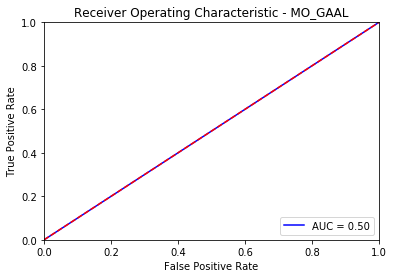

Accuracy:  0.8289666666666666
Precision:  0.0
Recall:  0.0
F1-score: -
Duration:  4628.671039  seconds




In [18]:
#Neural Networks tests
classifiers = {
    'AutoEncoder': AutoEncoder(contamination = outliers_fraction, hidden_neurons = [8, 4, 4, 8], epochs = 15),
    'SO_GAAL': SO_GAAL(contamination = outliers_fraction),
    'MO_GAAL': MO_GAAL(contamination = outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name, testingSet, testingSet)


Results - XGBoost:
Confusion Matrix:
               Actual
Predicted   3406  |  0
            0  |  16490 

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-score:  1.0
Duration:  7.729616  seconds


#####################################################################


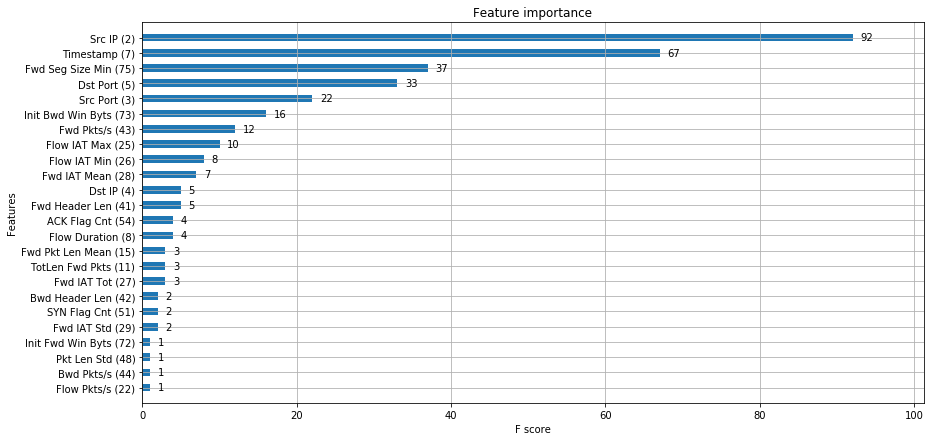

In [34]:
from xgboost import XGBClassifier, plot_importance

xgbo = XGBClassifier()
testMethod(xgbo, "XGBoost", trainingSet_pd, testingSet_pd, y_test, y_train)

#xgbo.fit(testingSet_pd, y_test)

plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(xgbo, height=0.5)
pyplot.show()

In [35]:
features_dict = xgbo.get_booster().get_fscore()

split_th = 3
for f, v in list(features_dict.items()):
    if(v < split_th):
        del features_dict[f]

print("\nFeatures:")
for f in features_dict:
    print(f)

testingSet_fs = pd.DataFrame()
for i in features_dict:
    serie = pd.Series(testingSet_pd[i])
    testingSet_fs[i] = serie


Features:
Fwd Seg Size Min (75)
Timestamp (7)
Src Port (3)
Src IP (2)
Dst Port (5)
Flow IAT Max (25)
Fwd IAT Tot (27)
Flow Duration (8)
Fwd Pkts/s (43)
Init Bwd Win Byts (73)
Fwd Header Len (41)
Dst IP (4)
TotLen Fwd Pkts (11)
Fwd IAT Mean (28)
Flow IAT Min (26)
ACK Flag Cnt (54)
Fwd Pkt Len Mean (15)


In [36]:
testingSet_fs

Fwd Seg Size Min (75)  Timestamp (7)  Src Port (3)    Src IP (2)  \
0                       20.0   1.519097e+09       52520.0  1.720311e+11   
1                        0.0   1.518830e+09          80.0  1.720311e+11   
2                       20.0   1.519131e+09       52409.0  2.120921e+11   
3                        0.0   1.519270e+09          80.0  1.720311e+11   
4                       20.0   1.519133e+09       55012.0  1.821903e+10   
...                      ...            ...           ...           ...   
19891                   20.0   1.519131e+09       50670.0  1.720311e+11   
19892                    8.0   1.519106e+09       55081.0  1.720311e+11   
19893                    0.0   1.499141e+09       62448.0  1.921680e+11   
19894                    8.0   1.519112e+09       49486.0  1.720311e+11   
19895                   40.0   1.519101e+09        2290.0  2.092220e+11   

       Dst Port (5)  Flow IAT Max (25)  Fwd IAT Tot (27)  Flow Duration (8)  \
0              80.0         10191500.0        34155459.0         34155459.0   
1           36338.0          4699513.0          118277.0          4817796.0   
2            3389.0           953164.0         1978592.0          1978592.0   
3           50941.0           540836.0          596229.0           596233.0   
4              80.0          1261906.0             384.0          1262323.0   
...             ...                ...               ...                ...   
19891          80.0              122.0             122.0              122.0   
19892          53.0             1030.0               0.0             1030.0   
19893         443.0            36866.0          114860.0           153076.0   
19894          53.0            13075.0               0.0            13075.0   
19895        3128.0          1002281.0         1002281.0          1002281.0   

       Fwd Pkts/s (43)  Init Bwd Win Byts (73)  Fwd Header Len (41)  \
0             0.146389                   298.0                100.0   
1             0.830255                   211.0                136.0   
2             4.043279                 62952.0                172.0   
3             6.708787                 32768.0                 92.0   
4             2.376571                   211.0                 72.0   
...                ...                     ...                  ...   
19891     16393.442623                    -1.0                 40.0   
19892       970.873786                    -1.0                  8.0   
19893        58.794324                   362.0                288.0   
19894        76.481836                    -1.0                  8.0   
19895         1.995448                    -1.0                 80.0   

         Dst IP (4)  TotLen Fwd Pkts (11)  Fwd IAT Mean (28)  \
0      7.202109e+10                   4.0       8.538865e+06   
1      1.821919e+10                 935.0       3.942567e+04   
2      1.720311e+11                1048.0       2.826560e+05   
3      1.821901e+10                 935.0       1.987430e+05   
4      1.720311e+11                  20.0       1.920000e+02   
...             ...                   ...                ...   
19891  2.305209e+10                   0.0       1.220000e+02   
19892  1.720310e+11                  40.0       0.000000e+00   
19893  1.722170e+11                1275.0       1.435750e+04   
19894  1.720310e+11                  43.0       0.000000e+00   
19895  1.720311e+11                   0.0       1.002281e+06   

       Flow IAT Min (26)  ACK Flag Cnt (54)  Fwd Pkt Len Mean (15)  
0                11236.0                1.0               0.800000  
1                    6.0                1.0             233.750000  
2                   75.0                0.0             131.000000  
3                    4.0                0.0             233.750000  
4                    3.0                0.0               6.666667  
...                  ...                ...                    ...  
19891              122.0                1.0         

In [39]:
#Proximity Based
classifiers = {
    #'COF': COF(contamination= outliers_fraction),  #Apresentou erros de execução.
    #'LOF': LOF(contamination = outliers_fraction),
    #'CBLOF':CBLOF(contamination= outliers_fraction),
    #'LOCI':LOCI(contamination= outliers_fraction),   #Travou a máquina de execução repetidas vezes.
    'HBOS': HBOS(contamination= outliers_fraction),
    'PCA': PCA(contamination= outliers_fraction),
    'Isolation Forest': IForest(contamination = outliers_fraction),
    #'Feature Bagging': FeatureBagging(contamination = outliers_fraction)
    #'AvgKNN': KNN(method='mean', contamination= outliers_fraction),
    #'MedKNN': KNN(method='median', contamination= outliers_fraction),
    #'SOD': SOD(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name, testingSet_pd, testingSet_pd, y_train)
    testMethod(clf, clf_name, testingSet_fs, testingSet_fs, y_train)


Results - HBOS:


IndexError: index 19896 is out of bounds for axis 0 with size 19896